In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
import xgboost

c:\users\jhkim6\pycharmprojects\gc\venv\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

In [4]:
from joblib import dump, load

In [5]:
import json

In [6]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'Malgun Gothic'})
import sklearn

# 마이너스 부호 깨짐 현상 해결
matplotlib.rcParams['axes.unicode_minus'] = False

In [7]:
# row 출력제한 해제
pd.set_option('display.max_row', 500)

# column 출력제한 해제
pd.set_option('display.max_columns', 100)

In [8]:
from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [9]:
from impyute.imputation.cs import mice, fast_knn

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from itertools import product
from scipy.stats import gaussian_kde
from scipy import stats

In [12]:
# import keras
# from keras import layers
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.callbacks import EarlyStopping

In [13]:
# import torch 
# from torch import nn,optim
# from torch.utils.data import DataLoader, Dataset
# import torch.nn.functional as F

# Data Load

In [14]:
with open('../input/DM_건강검진결과_토탈_피봇241014.json', encoding='utf-8') as f:
    js = json.loads(f.read())
raw = pd.DataFrame(js)

In [15]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227553 entries, 0 to 1227552
Columns: 136 entries, 검진년도 to 심장주위지방CT
dtypes: int64(4), object(132)
memory usage: 1.2+ GB


In [16]:
raw.columns

Index(['검진년도', 'UID', 'CU_REC_ID', 'SEX', 'BRDT', '검진당시나이', 'CU_INF_CONT',
       'ETL_REG_DTM', '백혈구(WBC)', '공복시혈당(FBS)',
       ...
       'Cortisol(스트레스호르몬)', '성장관련인자(IGF1)', 'Testosterone(테스토스테론)',
       '에스트라디올(Estradiol)', 'FSH(난포자극호르몬)', 'NK세포활성도검사', 'P(인)',
       '류마티스인자 (RA Factor)', '심장칼슘CT', '심장주위지방CT'],
      dtype='object', length=136)

## config 설정

In [17]:
# scaling_bool = True
scaling_bool = False

In [18]:
sample_len = 2000

In [19]:
XGB_bool = True
pyTorch_bool = False

In [20]:
# 높을수록 False, 낮을수록 True
target_cols_direction = [True, True, True] # 1안
# target_cols_direction = ['center', 'center', 'center'] # 2안

In [21]:
target_cols_ratio = [4, 2, 2]

In [22]:
target_cols_kde = [
    '총빌리루빈_kde',
    '직접빌리루빈_kde',
    '간접빌리루빈_kde',]

In [23]:
csv_path = './output/해독기능_담즙배설기능.csv'

In [24]:
model_path_man = './model/0102_man.pkl'

In [25]:
model_path_woman = './model/0102_woman.pkl'

## 연령대 제한

In [26]:
len(raw)

1227553

In [27]:
raw = raw[(raw['검진당시나이'] >= 20) & (raw['검진당시나이'] < 70)]
raw.reset_index(drop=True, inplace=True)

In [28]:
len(raw)

1213899

In [29]:
# df = raw.drop(['CU_INF_CONT', 'BRDT', 'ETL_REG_DTM', '검진완료일자',                           
#                # text
#                '심전도', '아질산염 (Nitrite)',
#                '갑상선초음파 (Thyroid Sono)', '위내시경 (Endo)', '상복부초음파 (Abdominal Sono)', '대장내시경',
#                '흉부X-선 (Chest PA)', '골밀도검사(BMD)', '경동맥초음파 (Carotid Sono)', '요추 CT', '뇌 CT', '동맥경화검사', '경추 CT',
#                '심장초음파 (Echocardio Sono)', '뇌MRI', '뇌MRA', '골밀도검사(허리)', '골밀도검사 (T-Score)', 
#                '위암혈액검사(Pepsinogen I)', 'Gastrin(가스트린)', 'Helicobactor pylori IgG(혈액)', 
#                'Helicobactor Pylori IgM(혈액)', '심장칼슘CT', '심장주위지방CT',
#               ], axis=1)

In [30]:
cols = ['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이',
#                '체중', '신장', '허리둘레', # 기본신체정보
                '총빌리루빈', '직접빌리루빈', '간접빌리루빈',
               ]

df = raw[cols]

In [31]:
df.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
0,2010,7282,2520,1,42,1.7,0.3,None
1,2010,7490,3638,1,39,0.9,0.3,0.6
2,2010,7915,3997,1,36,1.4,None,None
3,2010,8056,4745,1,42,0.7,0.2,None
4,2010,8457,3929,1,38,1.9,None,None


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213899 entries, 0 to 1213898
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   검진년도       1213899 non-null  object
 1   UID        1213899 non-null  int64 
 2   CU_REC_ID  1213899 non-null  int64 
 3   SEX        1213899 non-null  int64 
 4   검진당시나이     1213899 non-null  int64 
 5   총빌리루빈      1049384 non-null  object
 6   직접빌리루빈     985030 non-null   object
 7   간접빌리루빈     776312 non-null   object
dtypes: int64(4), object(4)
memory usage: 74.1+ MB


In [33]:
df.columns

Index(['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이', '총빌리루빈', '직접빌리루빈',
       '간접빌리루빈'],
      dtype='object')

In [34]:
# df.columns = ['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이', '체중', '신장', '허리둘레', '체질량지수', 
#              '갑상선자극호르몬', 'Free T4'
#              ]

In [35]:
df.describe()

,UID,CU_REC_ID,SEX,검진당시나이
count,1.213899e+06,1.213899e+06,1.213899e+06,1.213899e+06
mean,5.086762e+05,1.491305e+06,1.369421e+00,4.074524e+01
std,3.652092e+05,7.933459e+05,4.826483e-01,8.917396e+00
min,3.200000e+01,1.430000e+02,1.000000e+00,2.000000e+01
25%,2.212800e+05,6.799645e+05,1.000000e+00,3.400000e+01
50%,3.806200e+05,1.409842e+06,1.000000e+00,4.000000e+01
75%,8.361275e+05,2.173650e+06,2.000000e+00,4.800000e+01
max,1.473645e+06,2.871445e+06,2.000000e+00,6.900000e+01


## 그룹별 결측값을 대체, 종합검진과 공단검진 차이(누락)에 대한 대체

In [36]:
df.isnull().sum()

검진년도              0
UID               0
CU_REC_ID         0
SEX               0
검진당시나이            0
총빌리루빈        164515
직접빌리루빈       228869
간접빌리루빈       437587
dtype: int64

In [37]:
df_group = df.groupby(['UID', '검진년도'])

In [38]:
temp = df.columns.to_list()
for idx in ['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이']:
    temp.remove(idx)

In [39]:
temp

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [40]:
import time
start = time.time()
for col in temp:
    print('column :', col)
    df[col] = df_group[col].transform(lambda x: x.interpolate('nearest').ffill().bfill())
end = time.time()
print(f"{end - start:.5f} sec")

column : 총빌리루빈
column : 직접빌리루빈
column : 간접빌리루빈
2041.52645 sec


In [41]:
df.isnull().sum()

검진년도              0
UID               0
CU_REC_ID         0
SEX               0
검진당시나이            0
총빌리루빈        103543
직접빌리루빈       171105
간접빌리루빈       389962
dtype: int64

## nemeric으로 치환 못하는 수치들 결측치로 변환

In [42]:
numeric_col = df.columns

In [43]:
df[numeric_col] = df[numeric_col].apply(pd.to_numeric, errors='coerce')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213899 entries, 0 to 1213898
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   검진년도       1213899 non-null  int64  
 1   UID        1213899 non-null  int64  
 2   CU_REC_ID  1213899 non-null  int64  
 3   SEX        1213899 non-null  int64  
 4   검진당시나이     1213899 non-null  int64  
 5   총빌리루빈      1109378 non-null  float64
 6   직접빌리루빈     1040148 non-null  float64
 7   간접빌리루빈     822450 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 74.1 MB


In [45]:
df.describe()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
count,1.213899e+06,1.213899e+06,1.213899e+06,1.213899e+06,1.213899e+06,1.109378e+06,1.040148e+06,822450.000000
mean,2.021881e+03,5.086762e+05,1.491305e+06,1.369421e+00,4.074524e+01,9.503769e-01,2.900900e-01,0.626765
std,1.696427e+00,3.652092e+05,7.933459e+05,4.826483e-01,8.917396e+00,3.492701e+00,1.264842e+00,0.560990
min,2.010000e+03,3.200000e+01,1.430000e+02,1.000000e+00,2.000000e+01,-2.900000e-01,-3.500000e-01,-0.200000
25%,2.021000e+03,2.212800e+05,6.799645e+05,1.000000e+00,3.400000e+01,6.000000e-01,2.000000e-01,0.400000
50%,2.022000e+03,3.806200e+05,1.409842e+06,1.000000e+00,4.000000e+01,8.000000e-01,2.300000e-01,0.600000
75%,2.023000e+03,8.361275e+05,2.173650e+06,2.000000e+00,4.800000e+01,1.080000e+00,3.000000e-01,0.800000
max,2.024000e+03,1.473645e+06,2.871445e+06,2.000000e+00,6.900000e+01,1.553000e+03,5.470000e+02,191.000000


In [46]:
df_result = df.copy()

# 이상치 제거

In [47]:
len(df_result)

1213899

In [48]:
# IQR 기준 이상치 확인하는 함수
def findOutliers_column(x, column):
    q1 = x[column].quantile(0.25)
    q3 = x[column].quantile(0.75)
    iqr = q3 - q1
    threshold = 1.5
    minimum = q1 - (iqr * threshold)
    maximum = q3 + (iqr * threshold)
    print('minimum :', minimum, 'maximum :', maximum)
    y = x[(x[column] > maximum) | (x[column] < minimum)]
#     y = x[(x[column] <= maximum) & (x[column] >= minimum)]
#     print(y.info())
#     print(y.index)
    return y, minimum, maximum

def findOutliers_column_out(x, column, minimum, maximum):
    y = x[(x[column] > maximum) | (x[column] < minimum)]
    return y
    
# IQR 기준 이상치 확인하는 함수
def findOutliers(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    threshold = 1.5
    minimum = q1 - (iqr * threshold)
    maximum = q3 + (iqr * threshold)
    print(minimum)
    y = x[(x > maximum) | (x < minimum)]
#     return len(y)
    return y

## 이상치 컬럼 min, max 확인 및 drop

In [49]:
temp = df.columns.to_list()
for idx in ['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이']:
    temp.remove(idx)

In [50]:
# IQR 기준 이상치 개수 확인
# target_cols = [
#                '검진당시나이', 
# #                '체중', '신장', '허리둘레', '체질량지수(BMI)', #기본신체정보
#                'AST(SGOT)', 'ALT(SGPT)', 'ALP', 'r-GTP(GGT)', '유산탈수소효소 (LDH)', # 해독기능
#                '총빌리루빈', '직접빌리루빈', '간접빌리루빈', # 배설기능
#                ]
target_cols = temp

minimums = []
maximums = []

for col in target_cols:
    target_outlier, temp_min, temp_max = findOutliers_column(df_result, col)
    print(col, ':', len(df_result[col]),"/ IQR outliers: ", len(target_outlier), '/ ratio :', len(target_outlier)/len(df_result[col]))
    print()
    minimums.append(temp_min)
    maximums.append(temp_max)

for idx, col in enumerate(target_cols):    
    target_outlier = findOutliers_column_out(df_result, col, minimums[idx], maximums[idx])
    df_result = df_result.drop(target_outlier.index)
    df_result.reset_index(drop=True, inplace=True)

minimum : -0.12000000000000022 maximum : 1.8000000000000003
총빌리루빈 : 1213899 / IQR outliers:  29828 / ratio : 0.024572060772766104

minimum : 0.050000000000000044 maximum : 0.44999999999999996
직접빌리루빈 : 1213899 / IQR outliers:  88888 / ratio : 0.07322520242623151

minimum : -0.20000000000000007 maximum : 1.4000000000000001
간접빌리루빈 : 1213899 / IQR outliers:  16682 / ratio : 0.013742494227279205



In [51]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [52]:
minimums

[-0.12000000000000022, 0.050000000000000044, -0.20000000000000007]

In [53]:
maximums

[1.8000000000000003, 0.44999999999999996, 1.4000000000000001]

In [54]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115580 entries, 0 to 1115579
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   검진년도       1115580 non-null  int64  
 1   UID        1115580 non-null  int64  
 2   CU_REC_ID  1115580 non-null  int64  
 3   SEX        1115580 non-null  int64  
 4   검진당시나이     1115580 non-null  int64  
 5   총빌리루빈      1011134 non-null  float64
 6   직접빌리루빈     943967 non-null   float64
 7   간접빌리루빈     765753 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 68.1 MB


In [55]:
df_result.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
0,2010,7282,2520,1,42,1.7,0.3,NaN
1,2010,7490,3638,1,39,0.9,0.3,0.6
2,2010,7915,3997,1,36,1.4,NaN,NaN
3,2010,8056,4745,1,42,0.7,0.2,NaN
4,2010,11158,1703,1,37,0.8,0.2,0.6


In [56]:
len(df_result)

1115580

In [57]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115580 entries, 0 to 1115579
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   검진년도       1115580 non-null  int64  
 1   UID        1115580 non-null  int64  
 2   CU_REC_ID  1115580 non-null  int64  
 3   SEX        1115580 non-null  int64  
 4   검진당시나이     1115580 non-null  int64  
 5   총빌리루빈      1011134 non-null  float64
 6   직접빌리루빈     943967 non-null   float64
 7   간접빌리루빈     765753 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 68.1 MB


In [58]:
df_result.describe()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
count,1.115580e+06,1.115580e+06,1.115580e+06,1.115580e+06,1.115580e+06,1.011134e+06,943967.000000,765753.000000
mean,2.021874e+03,5.112173e+05,1.499164e+06,1.384422e+00,4.059580e+01,8.223292e-01,0.240874,0.580363
std,1.711032e+00,3.665471e+05,7.949056e+05,4.864587e-01,8.908885e+00,2.919100e-01,0.086084,0.238346
min,2.010000e+03,3.200000e+01,1.430000e+02,1.000000e+00,2.000000e+01,0.000000e+00,0.060000,-0.200000
25%,2.021000e+03,2.217900e+05,6.803678e+05,1.000000e+00,3.400000e+01,6.000000e-01,0.200000,0.400000
50%,2.022000e+03,3.818870e+05,1.442788e+06,1.000000e+00,4.000000e+01,8.000000e-01,0.200000,0.560000
75%,2.023000e+03,8.397590e+05,2.179531e+06,2.000000e+00,4.700000e+01,1.000000e+00,0.300000,0.700000
max,2.024000e+03,1.473645e+06,2.871445e+06,2.000000e+00,6.900000e+01,1.800000e+00,0.440000,1.400000


# target (건강지수) 계산

In [59]:
len(df_result)

1115580

## Linear Regression coefficient 계산

In [60]:
def LR_coef(df):
    df_ = df.copy()
#     df_.reset_index(drop=True, inplace=True)
    df_.fillna(df_.mean().round(2), inplace=True)
    print(len(df_))
    
    df_temp = pd.DataFrame()

    for age in range(df_['검진당시나이'].min(), df_['검진당시나이'].max()):
        temp_ = df_[df_['검진당시나이'] == age].sample(n = sample_len, replace=True)
        df_temp = pd.concat([df_temp, temp_])
        
    X_train, X_test, y_train, y_test = train_test_split(df_temp[target_cols], df_temp['검진당시나이'], test_size=0.25, random_state=87)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print('r2_score :',r2_score(y_test, y_pred))
    print('MAE :',mean_absolute_error(y_test, y_pred))
    print('model.coef_ :',model.coef_)
    print('model.intercept_ :',model.intercept_)
    
    df_['target_org'] = (model.coef_[0] * df_[target_cols[0]]) 
    + (model.coef_[1] * df_[target_cols[1]]) 
    + (model.coef_[2] * df_[target_cols[2]]) 
    + (model.coef_[3] * df_[target_cols[3]]) 
    + (model.coef_[4] * df_[target_cols[4]]) 
    + (model.coef_[5] * df_[target_cols[5]]) 
    + (model.coef_[6] * df_[target_cols[6]])
    + (model.coef_[7] * df_[target_cols[7]])
    
    df_['target'] = ((df_['target_org'] - df_['target_org'].min()) / (df_['target_org'].max() - df_['target_org'].min()))
        
    print('min :', df_['target_org'].min())
    print('max :', df_['target_org'].max())
    
    df_['target'] = (df_['target'] * 100) + 50
    
    df['target'] = df_['target']
    
    return df

In [61]:
# target_cols

In [62]:
# df_man = df_result[df_result['SEX'] == 1]
# df_man = LR_coef(df_man)

In [63]:
# df_man[df_man['target'].isna()]

In [64]:
# df_woman = df_result[df_result['SEX'] == 2]
# df_woman = LR_coef(df_woman)

In [65]:
# df_target = pd.concat([df_man, df_woman])

In [66]:
# len(df_target)

In [67]:
# df_target.dropna(subset=target_cols, how='all', inplace=True)
# df_target.reset_index(drop=True, inplace=True)

In [68]:
# len(df_target)

In [69]:
# df_target[df_target['target'].isna()]

In [70]:
# df_target.info()

In [71]:
# df_target.head()

In [72]:
# df_target['target'] = np.round(df_target['target'])
# df_target['target'] = df_target['target'].astype(int)

In [73]:
# len(df_target)

In [74]:
# df_target.describe()

In [75]:
# df_target[df_target['target'] == 50]

In [76]:
# df_target[df_target['target'] == 150]

## target (건강지수) 컬럼들간 mean으로 계산

In [77]:
# df_target = pd.DataFrame()

# for age in range(int(df_result['검진당시나이'].min()), int(df_result['검진당시나이'].max()) + 1):
# # for age in range(int(df_result['검진당시나이'].min()), 21):
    
#     df_cols = pd.DataFrame()
#     for col in target_cols:
#         df_temp = df_result[df_result['검진당시나이'] == age].copy()
#         df_temp['target_' + col] = ((df_temp[col] - df_temp[col].min()) / (df_temp[col].max() - df_temp[col].min()))
# #         print(age, df_temp[col].min(), df_temp[col].max(), df_temp[col].mean())
#         temp = df_temp['target_' + col].copy()
#         df_cols = pd.concat([df_cols, temp], axis=1)
    
#     df_cols['target'] = np.round(df_cols.mean(axis='columns') * 100) + 50
# #     df_target = pd.concat([df_target,pd.concat([df_result[df_result['검진당시나이'] == age].copy(), df_cols], axis=1)])
    
#     df_age = pd.concat([df_result[df_result['검진당시나이'] == age].copy(), df_cols['target']], axis=1)        
    
#     df_target = pd.concat([df_target, df_age])
    
# df_target.reset_index(drop=True, inplace=True)
# df_target.dropna(subset=['target'], inplace=True)
# df_target['target'] = df_target['target'].astype(int)

In [78]:
# len(df_target)

In [79]:
# df_target.head()

In [80]:
# df_target.info()

## gaussian_kde

In [81]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

<AxesSubplot:>

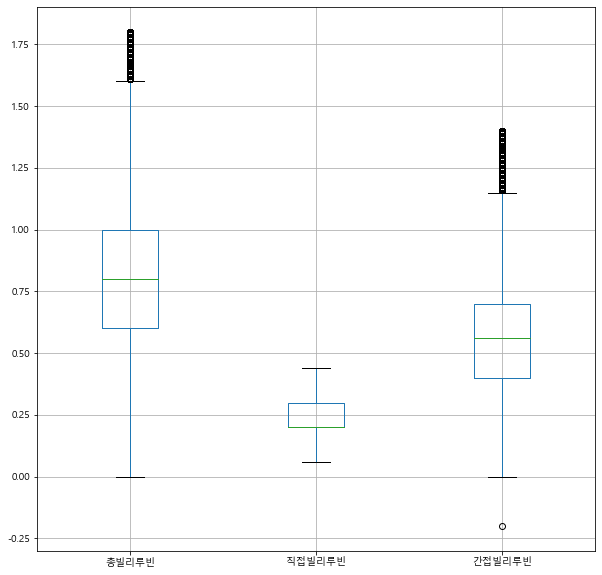

In [82]:
plt.rcParams["figure.figsize"] = (10, 10)
df_result.boxplot(column=target_cols)

In [83]:
df_result.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
0,2010,7282,2520,1,42,1.7,0.3,NaN
1,2010,7490,3638,1,39,0.9,0.3,0.6
2,2010,7915,3997,1,36,1.4,NaN,NaN
3,2010,8056,4745,1,42,0.7,0.2,NaN
4,2010,11158,1703,1,37,0.8,0.2,0.6


In [84]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [85]:
len(target_cols)

3

In [86]:
target_cols_direction

[True, True, True]

In [87]:
def kde_col(df, cols):
    
    threshold = 100
    max_threshold = 150
    
    df_target = pd.DataFrame() # return DF
    
    # 연령대별로 sample_len개 샘플링
    tmp_data = df.groupby(['SEX', '검진당시나이']).apply(
        lambda x: x.sample(sample_len, replace=True, random_state=42))

    tmp_data.reset_index(drop=True, inplace=True)
    
    # 성연령별 모델 생성
    for sex, age in product([1, 2], range(df['검진당시나이'].min(), df['검진당시나이'].max() + 1)):    
        tmp_data2 = tmp_data[tmp_data['SEX'] == sex]
        tmp_data3 = tmp_data2[tmp_data2['검진당시나이'] == age]
        
        df_temp = df[df['SEX'] == sex]
        df_temp = df_temp[df_temp['검진당시나이'] == age]
        df_temp.reset_index(drop=True, inplace=True)
            
        df_age = pd.DataFrame()
        
        for index, col in enumerate(cols):
        
            input_data = tmp_data3[col].copy()
            
            # 결측치가 많을 때 평균을 넣게 되면 평균쪽으로 쏠림
#             try:
#                 input_data.fillna(input_data.mean().round(0), inplace=True)
#             except:                
#                 input_data.fillna(tmp_data2[col].mean().round(0), inplace=True)

            input_data.dropna(inplace = True)
                
            input_data = input_data.sort_values()
            
            if len(input_data.value_counts()) > 1:
                # kde 모델
                kde = gaussian_kde(input_data)
                result = kde(input_data)
                max_value = result.max()            

                df_col = df_temp[col].copy()
                df_col.fillna(df_col.mean().round(0), inplace=True)

                # 방향성이 있을 경우
                max_idx = result.argmax()  # 최대값의 인덱스
                std_value = input_data.iloc[max_idx] # 인덱스 최대값의 밸류값

                '''
                display print
                '''
#                 print('')
#                 print('@@ col :',col)
#                 plt.rcParams["figure.figsize"] = (5, 5)
#                 print('sex :',sex)
#                 print('age :',age)
#                 fig = plt.figure()
#                 ax = fig.add_subplot(111)
#                 x_eval = np.linspace(50, 140, num=200)
#                 ax.plot(input_data, result, 'k-')                
#                 plt.show()
#                 print('max_value: ',max_value)
#                 print('std_value: ',std_value)

                arr = []

                temp = pd.DataFrame(kde(df_col), columns=['kde'])

                if target_cols_direction[index]:
                    # center right
                    temp['trigger'] = (df_col >= std_value)
                elif target_cols_direction[index] == False:
                    # center left
                    temp['trigger'] = (df_col < std_value)

                if target_cols_direction[index] != 'center':
                    temp['output'] = [(temp['kde'].iloc[idx] / max_value) * threshold if trigger else (1 + (1 - (temp['kde'].iloc[idx] / max_value))) * threshold
                                      for idx, trigger in temp['trigger'].iteritems()]
                else:                
                    temp['output'] = [(temp['kde'].iloc[idx] / max_value) * (threshold * 2) for idx, value in temp['kde'].iteritems()]

    #             temp['gap'] = abs(temp['output'] - threshold)            
    #             a = 11
    #             temp['adjusted_gap'] = [np.log(temp['gap'].iloc[idx]) * a if gap> np.e else gap for idx, gap in temp['gap'].iteritems()]            
    #             temp[col + '_kde'] = [threshold - temp['adjusted_gap'].iloc[idx] if trigger else threshold + temp['adjusted_gap'].iloc[idx] for idx, trigger in temp['trigger'].iteritems()]

                temp[col + '_kde'] = temp['output']
                temp[col + '_kde'] = temp[col + '_kde'].round(2)
            else:
                temp[col + '_kde'] = threshold
            
            df_age = pd.concat([df_age, temp[col + '_kde']], axis=1)

        df_temp = pd.concat([df_temp, df_age], axis=1)
        df_target = pd.concat([df_target, df_temp])
        df_target.reset_index(drop=True, inplace=True)
    
    # Null 이면 100
    for col in target_cols:
        for idx in df_target[col][df_target[col].isnull()].index:        
            df_target.loc[idx, col + '_kde'] = threshold
            
#     df_target['kde_mean'] = df_target.iloc[:, (5+len(cols)):(5+len(cols)+len(cols))].mean('columns').round(2)
    
#     for col in target_cols:
#         df_target.drop([col + '_kde'], axis = 1, inplace = True)
    
    df_target.sort_values(by='CU_REC_ID', inplace=True)
    
    return df_target

In [88]:
import time
start = time.time()
df_target = kde_col(df_result, target_cols)
end = time.time()
print(f"{end - start:.5f} sec")

545.17078 sec


## 검진 항목별 가중치 

In [89]:
df_target.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde
289647,2010,609272,143,1,40,0.61,0.12,NaN,126.01,181.60,100.0
572571,2010,585711,154,1,52,0.92,0.21,NaN,93.58,90.88,100.0
482914,2010,593983,156,1,48,0.85,0.23,NaN,99.71,44.53,100.0
264623,2010,612330,185,1,39,1.20,0.30,NaN,45.09,79.47,100.0
23461,2010,645901,212,1,28,0.80,0.20,NaN,99.82,100.00,100.0


In [90]:
target_cols_kde

['총빌리루빈_kde', '직접빌리루빈_kde', '간접빌리루빈_kde']

In [91]:
target_cols_ratio

[4, 2, 2]

In [92]:
sum(target_cols_ratio)

8

In [93]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115580 entries, 289647 to 161823
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   검진년도        1115580 non-null  int64  
 1   UID         1115580 non-null  int64  
 2   CU_REC_ID   1115580 non-null  int64  
 3   SEX         1115580 non-null  int64  
 4   검진당시나이      1115580 non-null  int64  
 5   총빌리루빈       1011134 non-null  float64
 6   직접빌리루빈      943967 non-null   float64
 7   간접빌리루빈      765753 non-null   float64
 8   총빌리루빈_kde   1115580 non-null  float64
 9   직접빌리루빈_kde  1115580 non-null  float64
 10  간접빌리루빈_kde  1115580 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 102.1 MB


In [94]:
df_target['kde_mean'] = (
      (target_cols_ratio[0] * df_target[target_cols_kde[0]])
    + (target_cols_ratio[1] * df_target[target_cols_kde[1]])
    + (target_cols_ratio[2] * df_target[target_cols_kde[2]])
) / sum(target_cols_ratio)

In [95]:
df_target['kde_mean'] = np.round(df_target['kde_mean'], 2)

In [96]:
df_target['kde_mean'].min()

1.2

In [97]:
df_target['kde_mean'].max()

197.94

In [98]:
df_target.describe()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean
count,1.115580e+06,1.115580e+06,1.115580e+06,1.115580e+06,1.115580e+06,1.011134e+06,943967.000000,765753.000000,1.115580e+06,1.115580e+06,1.115580e+06,1.115580e+06
mean,2.021874e+03,5.112173e+05,1.499164e+06,1.384422e+00,4.059580e+01,8.223292e-01,0.240874,0.580363,9.128499e+01,9.220279e+01,9.388909e+01,9.216546e+01
std,1.711032e+00,3.665471e+05,7.949056e+05,4.864587e-01,8.908885e+00,2.919100e-01,0.086084,0.238346,3.763428e+01,4.317313e+01,3.331550e+01,3.244441e+01
min,2.010000e+03,3.200000e+01,1.430000e+02,1.000000e+00,2.000000e+01,0.000000e+00,0.060000,-0.200000,9.000000e-02,1.670000e+00,1.300000e-01,1.200000e+00
25%,2.021000e+03,2.217900e+05,6.803678e+05,1.000000e+00,3.400000e+01,6.000000e-01,0.200000,0.400000,7.018000e+01,6.294000e+01,8.379000e+01,7.440000e+01
50%,2.022000e+03,3.818870e+05,1.442788e+06,1.000000e+00,4.000000e+01,8.000000e-01,0.200000,0.560000,9.964000e+01,1.000000e+02,1.000000e+02,9.761000e+01
75%,2.023000e+03,8.397590e+05,2.179531e+06,2.000000e+00,4.700000e+01,1.000000e+00,0.300000,0.700000,1.071800e+02,1.000000e+02,1.007700e+02,1.090200e+02
max,2.024000e+03,1.473645e+06,2.871445e+06,2.000000e+00,6.900000e+01,1.800000e+00,0.440000,1.400000,2.000000e+02,1.985200e+02,2.000000e+02,1.979400e+02


<AxesSubplot:>

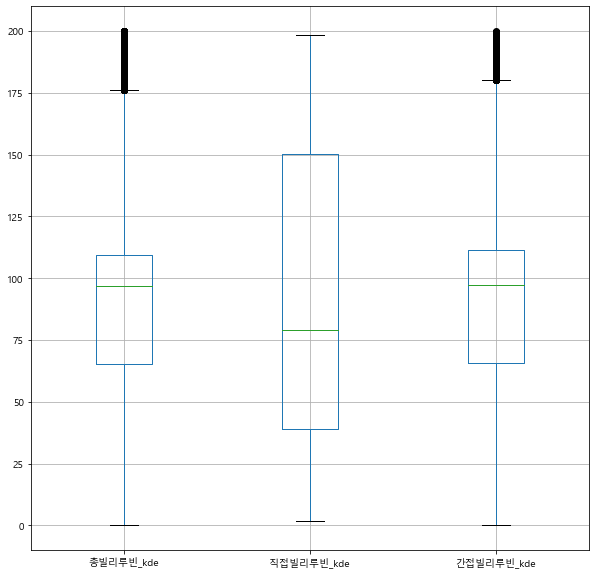

In [99]:
plt.rcParams["figure.figsize"] = (10, 10)
df_boxplot = df_target.copy()
df_boxplot.replace(100, np.NaN, inplace=True)
df_boxplot.boxplot(column=[
 '총빌리루빈_kde',
 '직접빌리루빈_kde',
 '간접빌리루빈_kde',])

<AxesSubplot:>

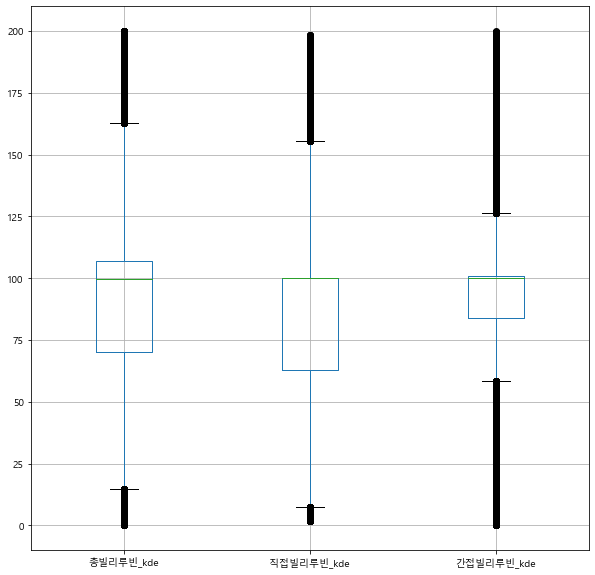

In [100]:
plt.rcParams["figure.figsize"] = (10, 10)
df_boxplot = df_target.copy()
# df_boxplot.replace(100, np.NaN, inplace=True)
df_boxplot.boxplot(column=[
 '총빌리루빈_kde',
 '직접빌리루빈_kde',
 '간접빌리루빈_kde',])

## target Scaling

In [101]:
# df_target['target'] = ((df_target['kde_mean'] - df_target['kde_mean'].min()) / (df_target['kde_mean'].max() - df_target['kde_mean'].min()))
df_target['target'] = ((df_target['kde_mean'] - 0) / (200 - 0))

In [102]:
df_target['target'] = (df_target['target'] * 100) + 50

In [103]:
df_target['target'] = df_target['target'].round(0)

In [104]:
df_target['target'].value_counts().reset_index().sort_values('index')

,index,target
96,51.0,75
91,52.0,583
82,53.0,1610
81,54.0,1810
78,55.0,2727
71,56.0,3598
72,57.0,3596
66,58.0,4305
67,59.0,4233
65,60.0,4364


In [105]:
df_target.describe()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
count,1.115580e+06,1.115580e+06,1.115580e+06,1.115580e+06,1.115580e+06,1.011134e+06,943967.000000,765753.000000,1.115580e+06,1.115580e+06,1.115580e+06,1.115580e+06,1.115580e+06
mean,2.021874e+03,5.112173e+05,1.499164e+06,1.384422e+00,4.059580e+01,8.223292e-01,0.240874,0.580363,9.128499e+01,9.220279e+01,9.388909e+01,9.216546e+01,9.608431e+01
std,1.711032e+00,3.665471e+05,7.949056e+05,4.864587e-01,8.908885e+00,2.919100e-01,0.086084,0.238346,3.763428e+01,4.317313e+01,3.331550e+01,3.244441e+01,1.622582e+01
min,2.010000e+03,3.200000e+01,1.430000e+02,1.000000e+00,2.000000e+01,0.000000e+00,0.060000,-0.200000,9.000000e-02,1.670000e+00,1.300000e-01,1.200000e+00,5.100000e+01
25%,2.021000e+03,2.217900e+05,6.803678e+05,1.000000e+00,3.400000e+01,6.000000e-01,0.200000,0.400000,7.018000e+01,6.294000e+01,8.379000e+01,7.440000e+01,8.700000e+01
50%,2.022000e+03,3.818870e+05,1.442788e+06,1.000000e+00,4.000000e+01,8.000000e-01,0.200000,0.560000,9.964000e+01,1.000000e+02,1.000000e+02,9.761000e+01,9.900000e+01
75%,2.023000e+03,8.397590e+05,2.179531e+06,2.000000e+00,4.700000e+01,1.000000e+00,0.300000,0.700000,1.071800e+02,1.000000e+02,1.007700e+02,1.090200e+02,1.050000e+02
max,2.024000e+03,1.473645e+06,2.871445e+06,2.000000e+00,6.900000e+01,1.800000e+00,0.440000,1.400000,2.000000e+02,1.985200e+02,2.000000e+02,1.979400e+02,1.490000e+02


<AxesSubplot:>

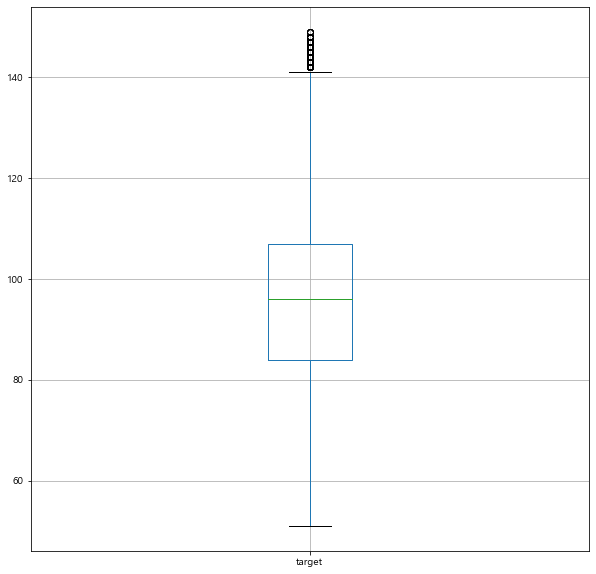

In [106]:
plt.rcParams["figure.figsize"] = (10, 10)
df_boxplot = df_target.copy()
df_boxplot.replace(100, np.NaN, inplace=True)
df_boxplot.boxplot(column=['target'])

<AxesSubplot:>

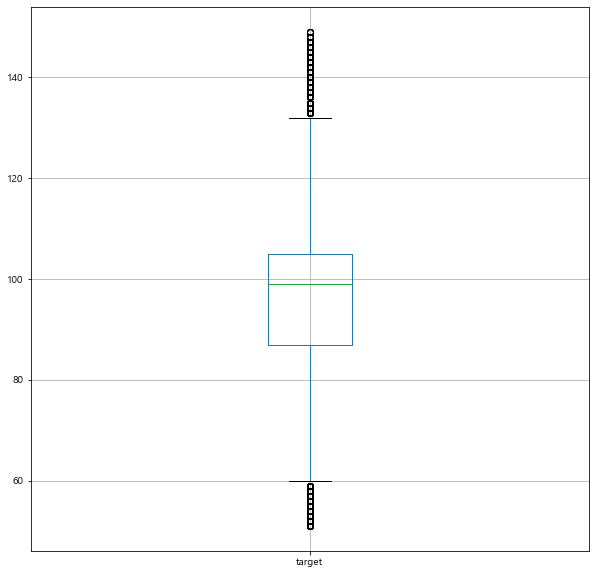

In [107]:
plt.rcParams["figure.figsize"] = (10, 10)
df_boxplot = df_target.copy()
# df_boxplot.replace(100, np.NaN, inplace=True)
df_boxplot.boxplot(column=['target'])

## target 계산 결과

<AxesSubplot:xlabel='검진당시나이'>

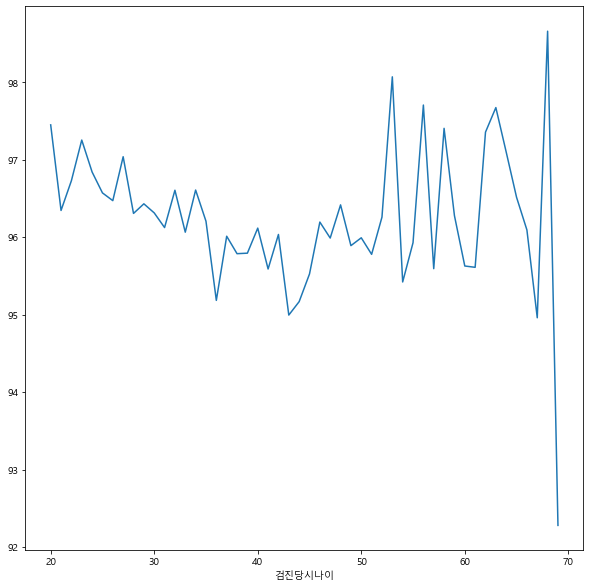

In [108]:
plt.rcParams["figure.figsize"] = (10, 10)
df_target.groupby('검진당시나이').mean()['target'].plot()

<AxesSubplot:xlabel='검진당시나이'>

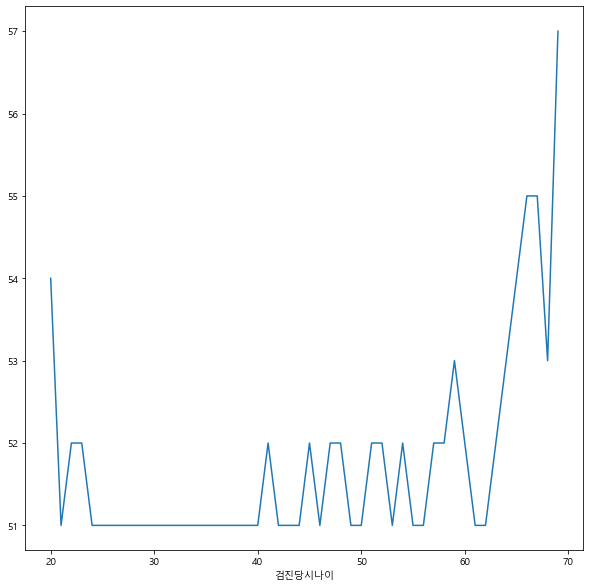

In [109]:
plt.rcParams["figure.figsize"] = (10, 10)
df_target.groupby('검진당시나이').min()['target'].plot()

<AxesSubplot:xlabel='검진당시나이'>

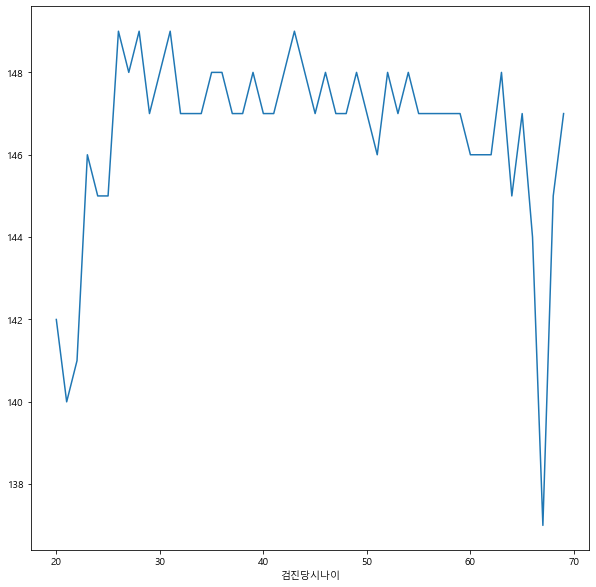

In [110]:
plt.rcParams["figure.figsize"] = (10, 10)
df_target.groupby('검진당시나이').max()['target'].plot()

In [111]:
df_target.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
289647,2010,609272,143,1,40,0.61,0.12,NaN,126.01,181.60,100.0,133.40,117.0
572571,2010,585711,154,1,52,0.92,0.21,NaN,93.58,90.88,100.0,94.51,97.0
482914,2010,593983,156,1,48,0.85,0.23,NaN,99.71,44.53,100.0,85.99,93.0
264623,2010,612330,185,1,39,1.20,0.30,NaN,45.09,79.47,100.0,67.41,84.0
23461,2010,645901,212,1,28,0.80,0.20,NaN,99.82,100.00,100.0,99.91,100.0


# 결측행 제거

In [112]:
# df_result.dropna(axis=0).info()

In [113]:
# df_result.dropna(axis=0, inplace=True)

# 남성 모델

In [114]:
df_target['SEX'].value_counts()

1    686726
2    428854
Name: SEX, dtype: int64

In [115]:
df_man = df_target[df_target['SEX'] == 1]
len(df_man)

686726

In [116]:
df_man.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
289647,2010,609272,143,1,40,0.61,0.12,NaN,126.01,181.60,100.0,133.40,117.0
572571,2010,585711,154,1,52,0.92,0.21,NaN,93.58,90.88,100.0,94.51,97.0
482914,2010,593983,156,1,48,0.85,0.23,NaN,99.71,44.53,100.0,85.99,93.0
264623,2010,612330,185,1,39,1.20,0.30,NaN,45.09,79.47,100.0,67.41,84.0
23461,2010,645901,212,1,28,0.80,0.20,NaN,99.82,100.00,100.0,99.91,100.0


# 결측치 처리

## 결측치 삭제

In [117]:
# df_man.dropna(inplace=True)

In [118]:
df_man.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
289647,2010,609272,143,1,40,0.61,0.12,NaN,126.01,181.60,100.0,133.40,117.0
572571,2010,585711,154,1,52,0.92,0.21,NaN,93.58,90.88,100.0,94.51,97.0
482914,2010,593983,156,1,48,0.85,0.23,NaN,99.71,44.53,100.0,85.99,93.0
264623,2010,612330,185,1,39,1.20,0.30,NaN,45.09,79.47,100.0,67.41,84.0
23461,2010,645901,212,1,28,0.80,0.20,NaN,99.82,100.00,100.0,99.91,100.0


## 결측치 평균으로 대체

In [119]:
# 결측치를 평균으로 대체 하는 함수
fill_mean_func = lambda g: g.fillna(g.mean().round(2))

In [120]:
# 나이로 group by, 결측치를 평균으로 대체
# df_man = df_man.groupby('검진당시나이').apply(fill_mean_func)

## 검진 항목 all 결측치 지우기

In [121]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [122]:
len(df_man)

686726

In [123]:
df_man.dropna(subset=target_cols, how='all', inplace=True)

In [124]:
len(df_man)

624965

In [125]:
df_man.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
289647,2010,609272,143,1,40,0.61,0.12,NaN,126.01,181.60,100.0,133.40,117.0
572571,2010,585711,154,1,52,0.92,0.21,NaN,93.58,90.88,100.0,94.51,97.0
482914,2010,593983,156,1,48,0.85,0.23,NaN,99.71,44.53,100.0,85.99,93.0
264623,2010,612330,185,1,39,1.20,0.30,NaN,45.09,79.47,100.0,67.41,84.0
23461,2010,645901,212,1,28,0.80,0.20,NaN,99.82,100.00,100.0,99.91,100.0


## fillna

In [126]:
df_man.mean().round(2)

검진년도             2022.00
UID            512758.51
CU_REC_ID     1487410.31
SEX                 1.00
검진당시나이             42.12
총빌리루빈               0.88
직접빌리루빈              0.25
간접빌리루빈              0.63
총빌리루빈_kde          91.45
직접빌리루빈_kde         89.71
간접빌리루빈_kde         93.63
kde_mean           91.56
target             95.79
dtype: float64

In [127]:
df_man.fillna(df_man.mean().round(2), inplace=True)

In [128]:
# df_man.fillna(0, inplace=True)

## IterativeImputer

In [129]:
# df_impute = pd.DataFrame(IterativeImputer(random_state=87).fit_transform(df_target))
# df_impute.columns = df.columns
# df_target = df_impute

## MICE(Multivariate Imputation by Chained Equation) Imputation

In [130]:
# import time
# start = time.time()
# np_imputed = mice(df_man.values) # mice 학습시작
# df_man = pd.DataFrame(np_imputed)
# end = time.time()
# print(f"{end - start:.5f} sec")

# 스크리닝

## 간접빌리루빈 스크리닝

In [131]:
screening = 0

In [132]:
df_man[df_man['간접빌리루빈'] < screening].head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
514732,2022,112632,1454579,1,49,0.88,0.39,-0.2,100.0,33.06,200.0,108.26,104.0


In [133]:
len(df_man[df_man['간접빌리루빈'] < screening])

1

In [134]:
df_man.loc[df_man['간접빌리루빈'] < screening, '간접빌리루빈'] = screening

In [135]:
df_man[df_man['간접빌리루빈'] < screening].head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target


In [136]:
len(df_man[df_man['간접빌리루빈'] < screening])

0

In [137]:
len(df_man)

624965

# 중복 제거

In [138]:
# 동일한 검진년도에 중복건을 제외하기 위해서 sort value 한다음 중복시 첫 번째것만 남겨둠
df_man.sort_values(by=['UID', '검진년도', 'CU_REC_ID'], ascending=[True, True, False], inplace=True)

In [139]:
df_man.head(20)

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
2192,2011,32,11757,1,24,1.10,0.25,0.63,66.22,100.00,100.00,83.11,92.0
594377,2019,50,356493,1,53,0.90,0.20,0.70,99.39,101.31,95.79,98.97,99.0
631177,2021,50,642497,1,55,0.90,0.10,0.80,95.61,184.13,70.95,111.58,106.0
290252,2019,62,421626,1,40,0.97,0.20,0.77,79.00,100.00,65.70,80.92,90.0
321970,2020,62,565527,1,41,0.93,0.20,0.73,83.97,100.00,73.21,85.29,93.0
350749,2021,62,699357,1,42,1.01,0.22,0.79,76.93,66.95,65.69,71.62,86.0
379975,2022,62,1356310,1,43,0.86,0.26,0.60,93.73,26.80,95.62,77.47,89.0
408936,2023,62,2170394,1,44,1.10,0.30,0.74,55.55,86.81,67.96,66.47,83.0
551340,2019,67,410099,1,51,0.54,0.20,0.63,140.43,100.00,100.00,120.22,110.0
574657,2020,67,481109,1,52,0.83,0.27,0.63,100.00,39.10,100.00,84.78,92.0


In [140]:
len(df_man)

624965

In [141]:
df_man[target_cols]

,총빌리루빈,직접빌리루빈,간접빌리루빈
2192,1.10,0.25,0.63
594377,0.90,0.20,0.70
631177,0.90,0.10,0.80
290252,0.97,0.20,0.77
321970,0.93,0.20,0.73
...,...,...,...
685343,0.50,0.20,0.30
685342,0.50,0.20,0.30
49265,1.00,0.30,0.70
11298,0.90,0.30,0.60


## first만 남겨두고 중복 제거

In [142]:
df_man = df_man.drop_duplicates(subset=['UID', '검진년도'], keep='first')

In [143]:
len(df_man)

532765

In [144]:
df_man.head(20)

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
2192,2011,32,11757,1,24,1.10,0.25,0.63,66.22,100.00,100.00,83.11,92.0
594377,2019,50,356493,1,53,0.90,0.20,0.70,99.39,101.31,95.79,98.97,99.0
631177,2021,50,642497,1,55,0.90,0.10,0.80,95.61,184.13,70.95,111.58,106.0
290252,2019,62,421626,1,40,0.97,0.20,0.77,79.00,100.00,65.70,80.92,90.0
321970,2020,62,565527,1,41,0.93,0.20,0.73,83.97,100.00,73.21,85.29,93.0
350749,2021,62,699357,1,42,1.01,0.22,0.79,76.93,66.95,65.69,71.62,86.0
379975,2022,62,1356310,1,43,0.86,0.26,0.60,93.73,26.80,95.62,77.47,89.0
408936,2023,62,2170394,1,44,1.10,0.30,0.74,55.55,86.81,67.96,66.47,83.0
551340,2019,67,410099,1,51,0.54,0.20,0.63,140.43,100.00,100.00,120.22,110.0
574657,2020,67,481109,1,52,0.83,0.27,0.63,100.00,39.10,100.00,84.78,92.0


In [145]:
df_man.reset_index(drop=True, inplace=True)

In [146]:
df_man.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
0,2011,32,11757,1,24,1.10,0.25,0.63,66.22,100.00,100.00,83.11,92.0
1,2019,50,356493,1,53,0.90,0.20,0.70,99.39,101.31,95.79,98.97,99.0
2,2021,50,642497,1,55,0.90,0.10,0.80,95.61,184.13,70.95,111.58,106.0
3,2019,62,421626,1,40,0.97,0.20,0.77,79.00,100.00,65.70,80.92,90.0
4,2020,62,565527,1,41,0.93,0.20,0.73,83.97,100.00,73.21,85.29,93.0


In [147]:
df_man.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532765 entries, 0 to 532764
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   검진년도        532765 non-null  int64  
 1   UID         532765 non-null  int64  
 2   CU_REC_ID   532765 non-null  int64  
 3   SEX         532765 non-null  int64  
 4   검진당시나이      532765 non-null  int64  
 5   총빌리루빈       532765 non-null  float64
 6   직접빌리루빈      532765 non-null  float64
 7   간접빌리루빈      532765 non-null  float64
 8   총빌리루빈_kde   532765 non-null  float64
 9   직접빌리루빈_kde  532765 non-null  float64
 10  간접빌리루빈_kde  532765 non-null  float64
 11  kde_mean    532765 non-null  float64
 12  target      532765 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 52.8 MB


# 연령별 개수 현황(검진당시나이)

<AxesSubplot:xlabel='index'>

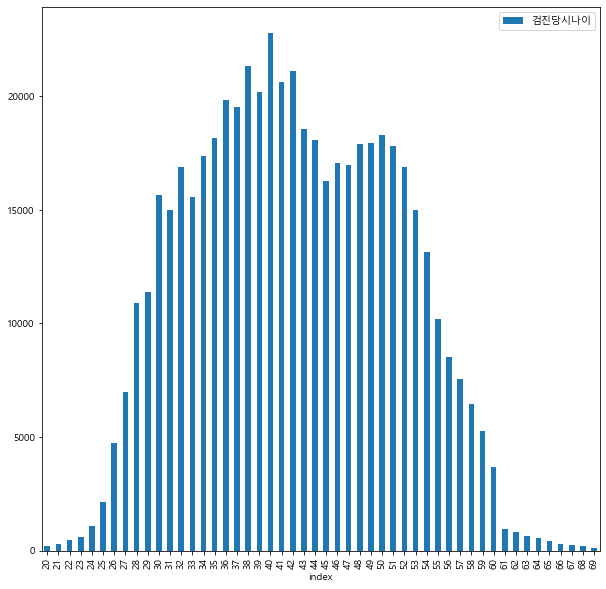

In [148]:
df_man['검진당시나이'].value_counts().reset_index().sort_values('index').plot.bar(x='index', y='검진당시나이')

In [149]:
df_man['검진당시나이'].value_counts().reset_index().sort_values('index')

,index,검진당시나이
48,20,180
45,21,271
42,22,455
40,23,597
36,24,1083
35,25,2151
33,26,4736
30,27,7003
26,28,10885
25,29,11401


# 검진항목 시각화

In [150]:
df_man.describe()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
count,532765.000000,5.327650e+05,5.327650e+05,532765.0,532765.000000,532765.000000,532765.000000,532765.000000,532765.000000,532765.000000,532765.000000,532765.000000,532765.000000
mean,2021.948476,5.062348e+05,1.476739e+06,1.0,42.147542,0.887397,0.253371,0.628641,90.880197,90.180534,93.415446,91.339089,95.674939
std,1.642916,3.609425e+05,8.172115e+05,0.0,8.791511,0.289456,0.080775,0.206138,38.486344,42.986387,34.317788,32.907193,16.462097
min,2010.000000,3.200000e+01,1.430000e+02,1.0,20.000000,0.000000,0.060000,0.000000,0.620000,4.110000,0.310000,2.720000,51.000000
25%,2021.000000,2.221110e+05,6.416880e+05,1.0,35.000000,0.700000,0.200000,0.500000,68.350000,67.380000,80.100000,71.850000,86.000000
50%,2022.000000,3.807580e+05,1.386429e+06,1.0,42.000000,0.870000,0.250000,0.630000,97.630000,100.000000,100.000000,94.180000,97.000000
75%,2023.000000,8.322930e+05,2.191333e+06,1.0,49.000000,1.100000,0.300000,0.700000,108.690000,100.000000,101.680000,108.800000,104.000000
max,2024.000000,1.473602e+06,2.871357e+06,1.0,69.000000,1.800000,0.440000,1.400000,200.000000,198.520000,200.000000,197.940000,149.000000


<AxesSubplot:xlabel='검진당시나이'>

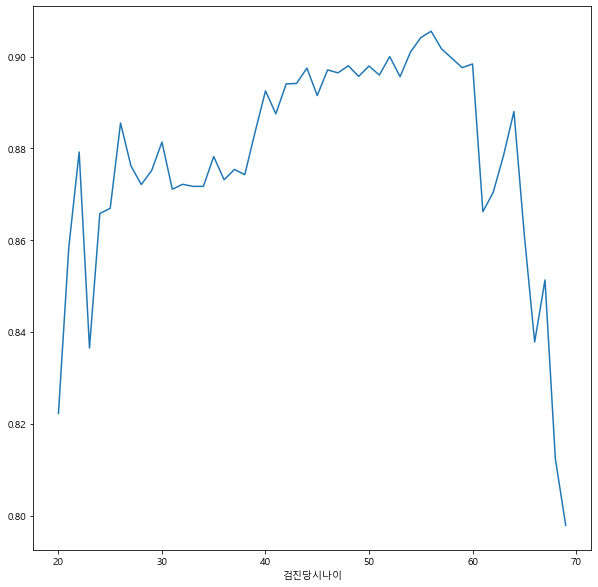

In [151]:
df_man.groupby('검진당시나이').mean()[target_cols[0]].plot()

<AxesSubplot:xlabel='검진당시나이'>

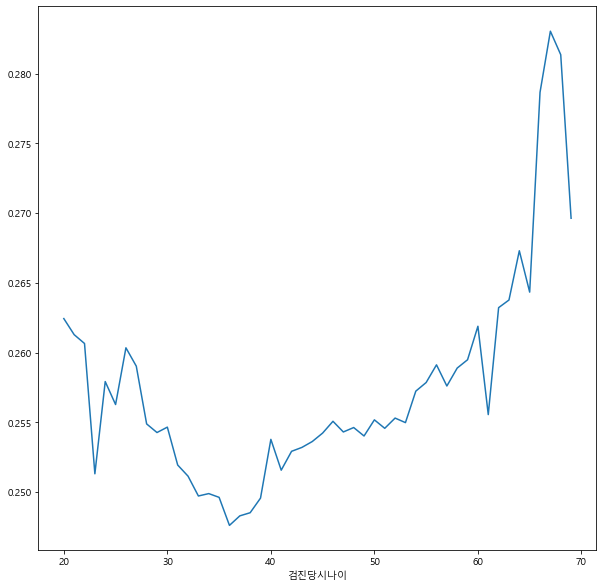

In [152]:
df_man.groupby('검진당시나이').mean()[target_cols[1]].plot()

<AxesSubplot:xlabel='검진당시나이'>

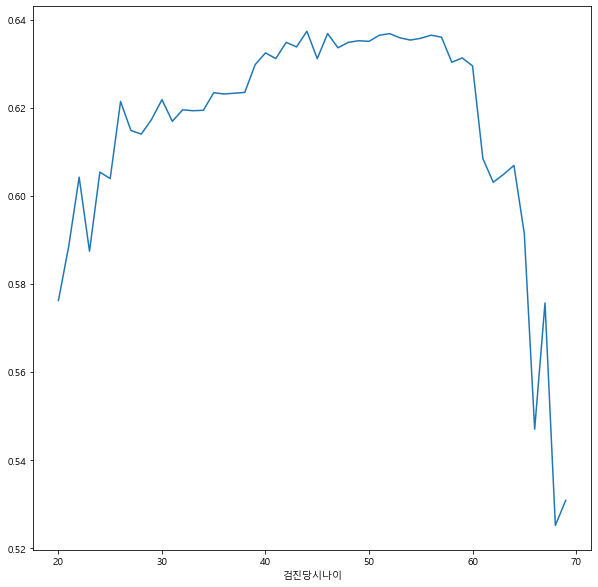

In [153]:
df_man.groupby('검진당시나이').mean()[target_cols[2]].plot()

<AxesSubplot:xlabel='검진당시나이', ylabel='target'>

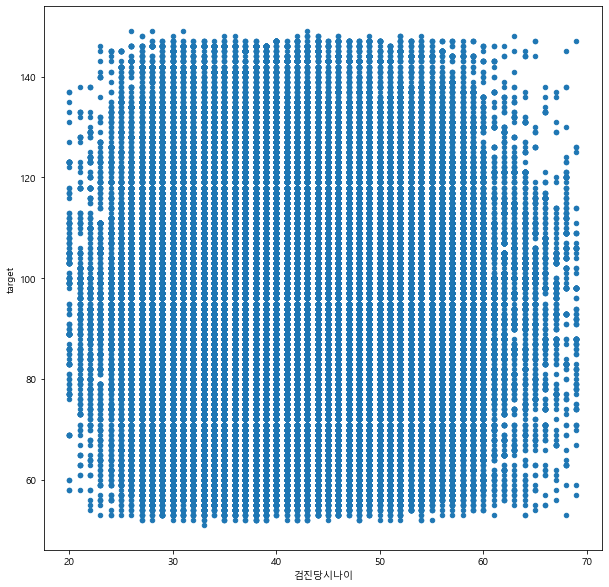

In [154]:
df_man.plot.scatter(x='검진당시나이', y='target')

# 건강지수 Sampling

<AxesSubplot:xlabel='index'>

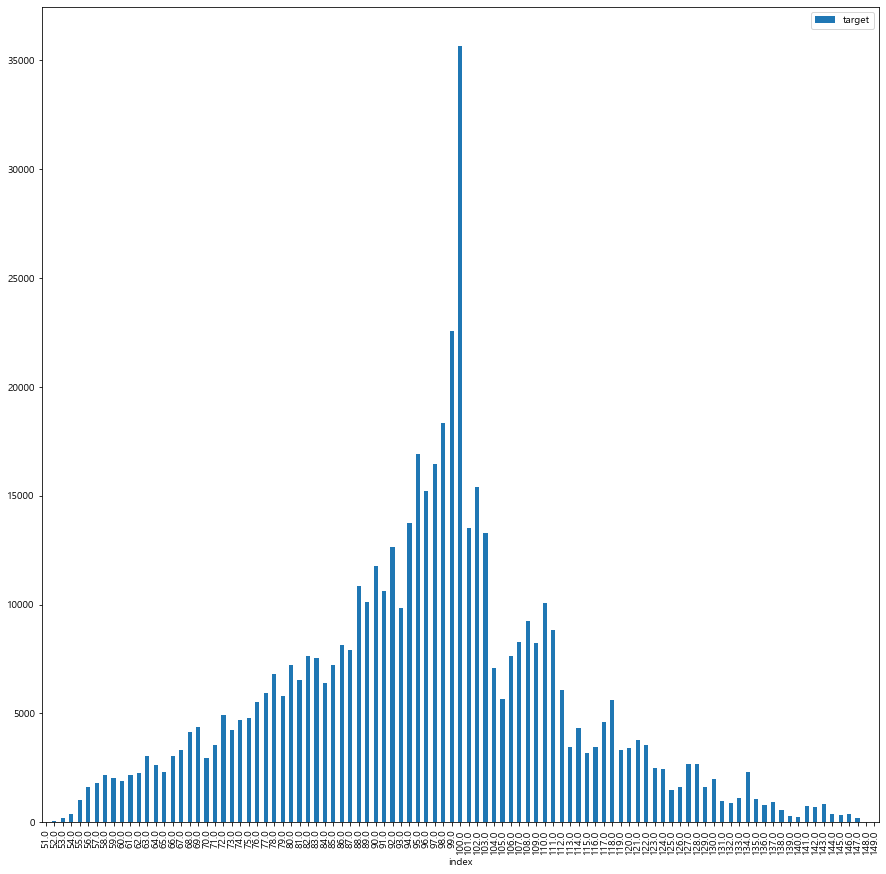

In [155]:
plt.rcParams["figure.figsize"] = (15, 15)
df_man['target'].value_counts().reset_index().sort_values('index').plot.bar(x='index', y='target')

In [156]:
df_man['target'].value_counts().reset_index().sort_values('index')

,index,target
98,51.0,1
95,52.0,39
93,53.0,197
87,54.0,387
78,55.0,1006
72,56.0,1640
71,57.0,1789
66,58.0,2191
68,59.0,2017
70,60.0,1896


In [157]:
df_man_sampling = pd.DataFrame()

# for target in range(int(df_man['target'].min()), 100):
for target in range(50, 100):
#     print(target, 200 - target)
    left_len = len(df_man[df_man['target'] == target])
    right_len = len(df_man[df_man['target'] == (200 - target)])
    
#     print(target, left_len, right_len)
    
    if left_len >= right_len:
        if left_len > 0:
            df_man_sampling = pd.concat([df_man_sampling, df_man[df_man['target'] == target].sample(left_len, replace=True, random_state=87)])
        if right_len > 0:
            df_man_sampling = pd.concat([df_man_sampling, df_man[df_man['target'] == (200 - target)].sample(left_len, replace=True, random_state=87)])
    else:
        if left_len > 0:
            df_man_sampling = pd.concat([df_man_sampling, df_man[df_man['target'] == target].sample(right_len, replace=True, random_state=87)])
        if right_len > 0:
            df_man_sampling = pd.concat([df_man_sampling, df_man[df_man['target'] == (200 - target)].sample(right_len, replace=True, random_state=87)])   

df_man_sampling = pd.concat([df_man_sampling, df_man[df_man['target'] == 100]])                    

In [158]:
# df_man = df_man_sampling.copy()

<AxesSubplot:xlabel='index'>

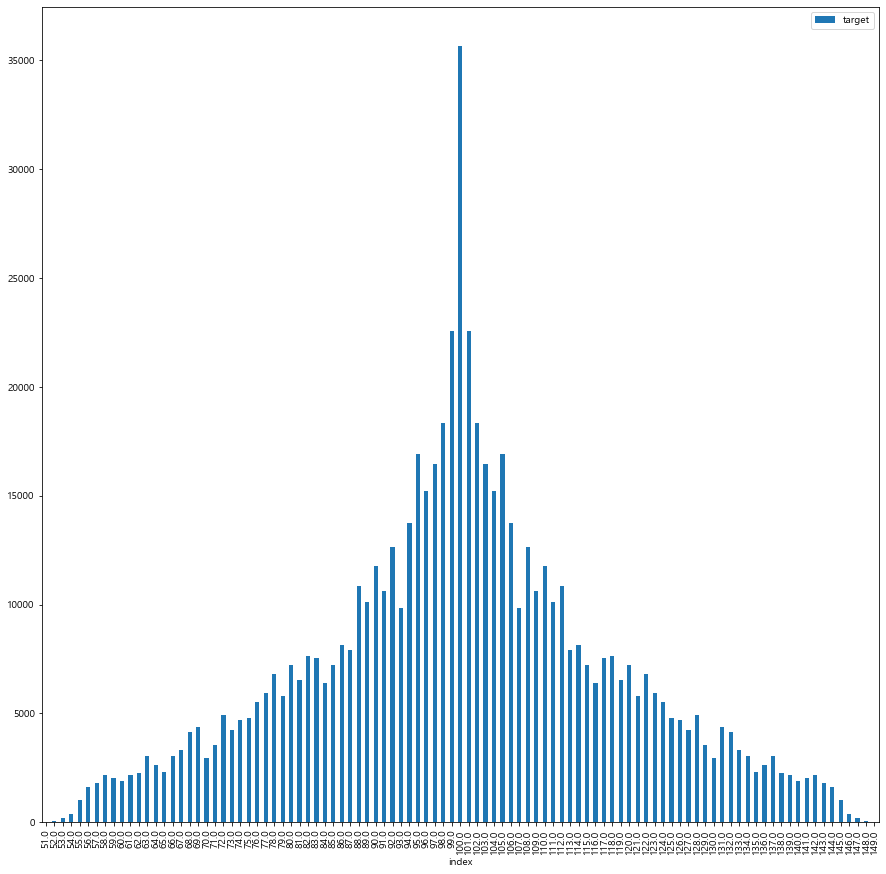

In [159]:
plt.rcParams["figure.figsize"] = (15, 15)
df_man_sampling['target'].value_counts().reset_index().sort_values('index').plot.bar(x='index', y='target')

In [160]:
df_man_sampling['target'].value_counts().reset_index().sort_values('index')

,index,target
98,51.0,4
95,52.0,39
94,53.0,197
92,54.0,387
90,55.0,1006
88,56.0,1640
86,57.0,1789
77,58.0,2191
82,59.0,2017
83,60.0,1896


# 나이별 확인하기

In [161]:
# target = 'target'

In [162]:
# df_man_sample = None
                 
# for idx in range(int(df_man[target].min()), int(df_man[target].max() + 1)):    
#     if len(df_man[df_man[target] == idx]) > 0:
#         temp_ = df_man[df_man[target] == idx].sample(n = sample_len, replace=True)
# #     df_impute = pd.DataFrame(IterativeImputer(random_state=87).fit_transform(temp))
# #     print(df_impute.columns)
# #     df_impute.columns = df_man.columns
    
# #     np_imputed = mice(temp.values)
# #     np_imputed = fast_knn(temp.values, k=5)
# #     df_impute = pd.DataFrame(np_immputed)
# #     temp = df_impute
    
#         df_man_sample = pd.concat([df_man_sample, temp_])

# df_man_sample.sample(frac=1).reset_index(drop=True, inplace=True)

In [163]:
# df_man = df_man_sample

In [164]:
# int(df_man['검진당시나이'].value_counts().mean())

In [165]:
# df_man['검진당시나이'].min()

In [166]:
# df_man['검진당시나이'].max()

In [167]:
# df_man.columns

In [168]:
# df_temp = None
# # sample_len = int(df_man['검진당시나이'].value_counts().mean())
# # sample_len = 1000
                 
# for age in range(df_man['검진당시나이'].min(), df_man['검진당시나이'].max()):
#     temp_ = df_man[df_man['검진당시나이'] == age].sample(n = sample_len, replace=True)
# #     df_impute = pd.DataFrame(IterativeImputer(random_state=87).fit_transform(temp))
# #     print(df_impute.columns)
# #     df_impute.columns = df_man.columns
    
# #     np_imputed = mice(temp.values)
# #     np_imputed = fast_knn(temp.values, k=5)
# #     df_impute = pd.DataFrame(np_immputed)
# #     temp = df_impute
    
#     df_temp = pd.concat([df_temp, temp_])

In [169]:
# df_temp.info()

In [170]:
# df_temp.reset_index(drop=True, inplace=True)

In [171]:
# df_man = df_temp.copy()

In [172]:
# df_man['검진당시나이'].value_counts()

In [173]:
# df_man[df_man['검진당시나이']==38]

In [174]:
# df_man[df_man['검진당시나이']==38]['UID'].value_counts()

# model train

In [175]:
df_man.columns

Index(['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이', '총빌리루빈', '직접빌리루빈',
       '간접빌리루빈', '총빌리루빈_kde', '직접빌리루빈_kde', '간접빌리루빈_kde', 'kde_mean',
       'target'],
      dtype='object')

In [176]:
# train_columns = [
# #                '체중', '신장', '허리둘레', '체질량지수(BMI)',
#                'AST(SGOT)', 'ALT(SGPT)', 'ALP', 'r-GTP(GGT)', '유산탈수소효소 (LDH)', # 해독기능
#                '총빌리루빈', '직접빌리루빈', '간접빌리루빈', # 배설기능
#                  ]

In [177]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [178]:
train_columns = target_cols.copy()

In [179]:
train_columns.insert(0, '검진당시나이')

In [180]:
target_col = 'target'

## Min Max Scaling

In [181]:
from sklearn.preprocessing import MinMaxScaler

In [182]:
scaling_bool

False

In [183]:
if scaling_bool:
    scaler = MinMaxScaler()
    data_scaler = scaler.fit_transform(df_man_sampling[train_columns])
    df_man_scaled = pd.DataFrame(data=data_scaler, columns=train_columns)

## train_test_split

In [184]:
if scaling_bool:
    X_train, X_test, y_train, y_test = train_test_split(df_man_scaled[train_columns], df_man_sampling[target_col], test_size=0.25, random_state=87)
else :
    X_train, X_test, y_train, y_test = train_test_split(df_man_sampling[train_columns], df_man_sampling[target_col], test_size=0.25, random_state=87)

## Linear Regression

In [185]:
# model = LinearRegression()

In [186]:
# model.fit(X_train, y_train)

In [187]:
# model.intercept_

In [188]:
# model.coef_

## Randomized SearchCV, 파라미터 튜닝

In [189]:
model = XGBRegressor()

In [190]:
# A parameter grid for XGBoost
params = {
    'n_estimators':[500],
#     'min_child_weight':[4,5], 
#     'gamma':[i/10.0 for i in range(3,6)],  
#     'subsample':[i/10.0 for i in range(6,11)],
#     'colsample_bytree':[i/10.0 for i in range(6,11)], 
#     'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

In [191]:
# run randomized search
n_iter_search = 10

random_search = RandomizedSearchCV(model, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

In [192]:
import time
start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))# best parameter

RandomizedSearchCV took 2271.79 seconds for 10 candidates parameter settings.


In [193]:
# best parameter
random_search.best_params_

{'objective': 'reg:squarederror',
 'n_estimators': 500,
 'eval_metric': 'rmse',
 'eta': 0.5,
 'booster': 'gbtree'}

In [194]:
# best score
random_search.best_score_

-0.3711478359321624

In [195]:
model = random_search.best_estimator_
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.5,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Keras

In [196]:
# def build_model():
#     model = keras.Sequential([
#         layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(16, activation='relu'),
#         layers.Dense(4, activation='relu'),
#         layers.Dense(1)
#     ])

#     optimizer = keras.optimizers.RMSprop(0.001)
    
#     model.compile(loss='mse',
#                 optimizer=optimizer,
#                 metrics=['mae', 'mse'])
    
#     return model

In [197]:
# model = build_model()

In [198]:
# # 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
# class PrintDot(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs):
#         if epoch % 10 == 0: print('')
#         print('.', end='')

# EPOCHS = 100

# # patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
# early_stop = EarlyStopping(monitor='val_loss', patience=10)

# history = model.fit(
#     X_train, y_train,
#     epochs=EPOCHS, validation_split=0.2, verbose=0,
#     callbacks=[early_stop, PrintDot()])
# #     callbacks=[PrintDot()])

In [199]:
# model.summary()

In [200]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()

In [201]:
# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

#     plt.figure(figsize=(8,12))

#     plt.subplot(2,1,1)
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Abs Error [MPG]')
#     plt.plot(hist['epoch'], hist['mae'], label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
# #     plt.ylim([0,5])
#     plt.legend()

#     plt.subplot(2,1,2)
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error [$MPG^2$]')
#     plt.plot(hist['epoch'], hist['mse'], label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
# #     plt.ylim([0,20])
#     plt.legend()
#     plt.show()

In [202]:
# plot_history(history)

## pyTorch 신경망

In [203]:
np.shape(X_train)[1]

4

In [204]:
# class Regressor(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(np.shape(X_train)[1], 100) #첫 번째 레이어 
#         self.fc2 = nn.Linear(100, 50) #두 번째 레이어
#         self.fc3 = nn.Linear(50, 1) #출력 레이어 
# #         self.dropout = nn.Dropout(0.5) #연산 마다 50%의 노드를 랜덤하게 없앤다
# #         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x)) #활성화 함수 적용                 
# #         x = self.dropout(F.relu(self.fc2(x))) #은닉층에서 전달할 때, 50% 를 dropout 
#         x = F.relu(self.fc2(x)) #활성화 함수 적용 
#         x = F.relu(self.fc3(x))
# #         x = self.fc1(x)
# #         x = self.fc2(x)
# #         x = self.fc3(x)
# #         x = self.relu(x)
#         return x

In [205]:
# model = Regressor()
# reg_loss = nn.MSELoss()
# # optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [206]:
# epochs = 1000

In [207]:
# X_train  = torch.Tensor(X_train.to_numpy())
# X_test  = torch.Tensor(X_test.to_numpy())
# y_train  = torch.Tensor(y_train.to_numpy().reshape(-1, 1))
# y_test  = torch.Tensor(y_test.to_numpy().reshape(-1, 1))

In [208]:
# losses = []

# # 총 100번의 에포크 동안 모델 학습
# for epoch in range(epochs):
#     optimizer.zero_grad()      # 옵티마이저의 기울기 초기화
#     y_pred = model(X_train)          # 순전파 연산으로 예측값 계산
#     loss = reg_loss(y_pred, y_train)  # 손실 함수로 비용 계산
#     loss.backward()            # 역전파 연산으로 기울기 계산
#     optimizer.step()           # 옵티마이저를 통해 파라미터 업데이트

#     # 10번째 에포크마다 현재 에포크와 손실 값 출력
#     if epoch % 100 == 0:
#         print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, epochs, loss.item()))

#     # 손실 값을 리스트에 추가하여 추적
#     losses.append(loss.item())

In [209]:
# plt.plot(losses)

## coef 계산

In [210]:
# df_coef = pd.concat([pd.DataFrame(train_columns).reset_index(drop=True), pd.DataFrame(model.coef_).reset_index(drop=True)], axis=1)

In [211]:
# df_coef.columns = ['검사항목', 'coef']

In [212]:
# df_coef['coef'] = df_coef['coef'].round(4)

In [213]:
# df_coef['abs_coef'] = df_coef['coef'].abs()

In [214]:
# df_coef.sort_values('abs_coef', ascending=False)

## Linear Regression Poly

In [215]:
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, include_bias=False)

In [216]:
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.fit_transform(X_test)

In [217]:
# slr = LinearRegression()

In [218]:
# slr.fit(X_train_poly, y_train)

In [219]:
# np.shape(X_train)

In [220]:
# np.shape(X_train_poly)

In [221]:
# np.shape(X_test)

In [222]:
# np.shape(X_test_poly)

In [223]:
# y_pred_poly = slr.predict(X_test_poly)

In [224]:
# '''
# 성능 평가
# '''
# # MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
# print('MAE :',mean_absolute_error(y_test, y_pred_poly))
# # MSE (Mean Squared Error) : 실제 값과 예측 값의 차이를 제곱해 평균화
# print('MSE :', mean_squared_error(y_test, y_pred_poly))
# #  RMSE (Root Mean Squared Error) : MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 RMSE 값을 사용
# print('RMSE :', np.sqrt(mean_squared_error(y_test, y_pred_poly)))

In [225]:
# from sklearn.metrics import r2_score
# r2_score(y_test, y_pred_poly)

# model save

In [226]:
import pickle
with open(model_path_man,'wb') as f:
    pickle.dump(model, f)

In [227]:
import pickle
with open(model_path_man, 'rb') as f:
    model = pickle.load(f) 

# 성능 평가

## pyTorch 예측

In [228]:
pyTorch_bool

False

In [229]:
if pyTorch_bool:
    # Get predictions, 
    with torch.no_grad():
        model.eval()
        y_pred = model(X_test)
        y_pred = y_pred.numpy()

## XGBRegressor

In [230]:
XGB_bool

True

In [231]:
if XGB_bool:
    y_pred = model.predict(X_test)

In [232]:
'''
성능 평가
'''
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
print('MAE :',mean_absolute_error(y_test, y_pred))
# MSE (Mean Squared Error) : 실제 값과 예측 값의 차이를 제곱해 평균화
print('MSE :', mean_squared_error(y_test, y_pred))
#  RMSE (Root Mean Squared Error) : MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 RMSE 값을 사용
print('RMSE :', np.sqrt(mean_squared_error(y_test, y_pred)))

MAE : 0.23823922110751541
MSE : 0.3774880942424582
RMSE : 0.6144005975277516


In [233]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9988303704485617

In [234]:
model.score(X_test, y_test)

0.9988303704485617

## feature importance

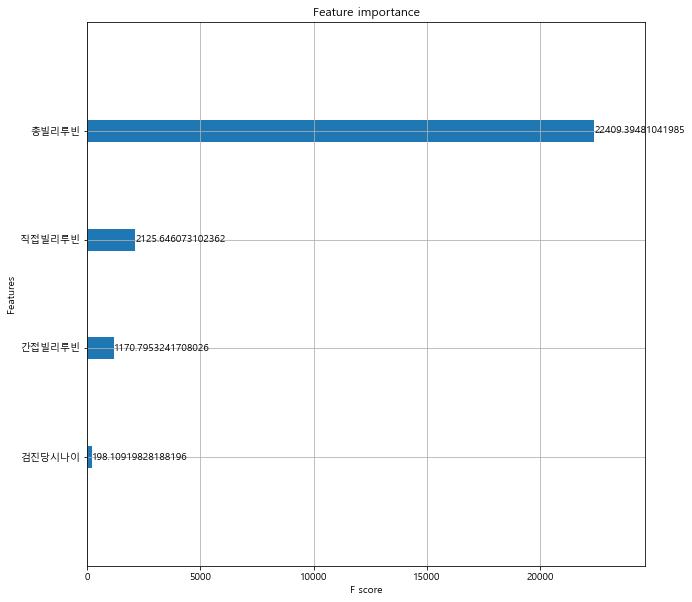

In [235]:
if XGB_bool:
    plt.rcParams["figure.figsize"] = (10, 10)
    xgboost.plot_importance(model, importance_type='gain')

In [236]:
model.feature_importances_

array([0.00764784, 0.8650958 , 0.08205877, 0.04519757], dtype=float32)

In [237]:
df_feature = pd.concat([pd.DataFrame(train_columns), pd.DataFrame(model.feature_importances_)], axis=1)
df_feature.columns = ['columns', 'feature_importance']

In [238]:
df_feature.sort_values('feature_importance', ascending=False)

,columns,feature_importance
1,총빌리루빈,0.865096
2,직접빌리루빈,0.082059
3,간접빌리루빈,0.045198
0,검진당시나이,0.007648


# 실제지수 - 예측지수 결과

In [239]:
pd.DataFrame(y_test).reset_index(drop=True)

,target
0,106.0
1,125.0
2,121.0
3,108.0
4,110.0
...,...
166605,130.0
166606,129.0
166607,83.0
166608,102.0


In [240]:
pd.DataFrame(y_pred).reset_index(drop=True)

,0
0,105.636063
1,125.145523
2,120.936905
3,108.095734
4,110.043137
...,...
166605,129.735260
166606,129.256042
166607,83.019409
166608,101.814491


In [241]:
df_test = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(y_pred).reset_index(drop=True)], axis=1)

In [242]:
df_test.head()

,target,0
0,106.0,105.636063
1,125.0,125.145523
2,121.0,120.936905
3,108.0,108.095734
4,110.0,110.043137


In [243]:
df_test.columns

Index(['target', 0], dtype='object')

In [244]:
df_test.columns = ['실제지수', '예측지수']

In [245]:
df_test['diff'] = df_test['예측지수'] - df_test['실제지수']

In [246]:
df_test.head()

,실제지수,예측지수,diff
0,106.0,105.636063,-0.363937
1,125.0,125.145523,0.145523
2,121.0,120.936905,-0.063095
3,108.0,108.095734,0.095734
4,110.0,110.043137,0.043137


In [247]:
df_test['diff_int'] = df_test['diff'].round(0)

In [248]:
len(df_test)

166610

In [249]:
df_test.head()

,실제지수,예측지수,diff,diff_int
0,106.0,105.636063,-0.363937,-0.0
1,125.0,125.145523,0.145523,0.0
2,121.0,120.936905,-0.063095,-0.0
3,108.0,108.095734,0.095734,0.0
4,110.0,110.043137,0.043137,0.0


<AxesSubplot:>

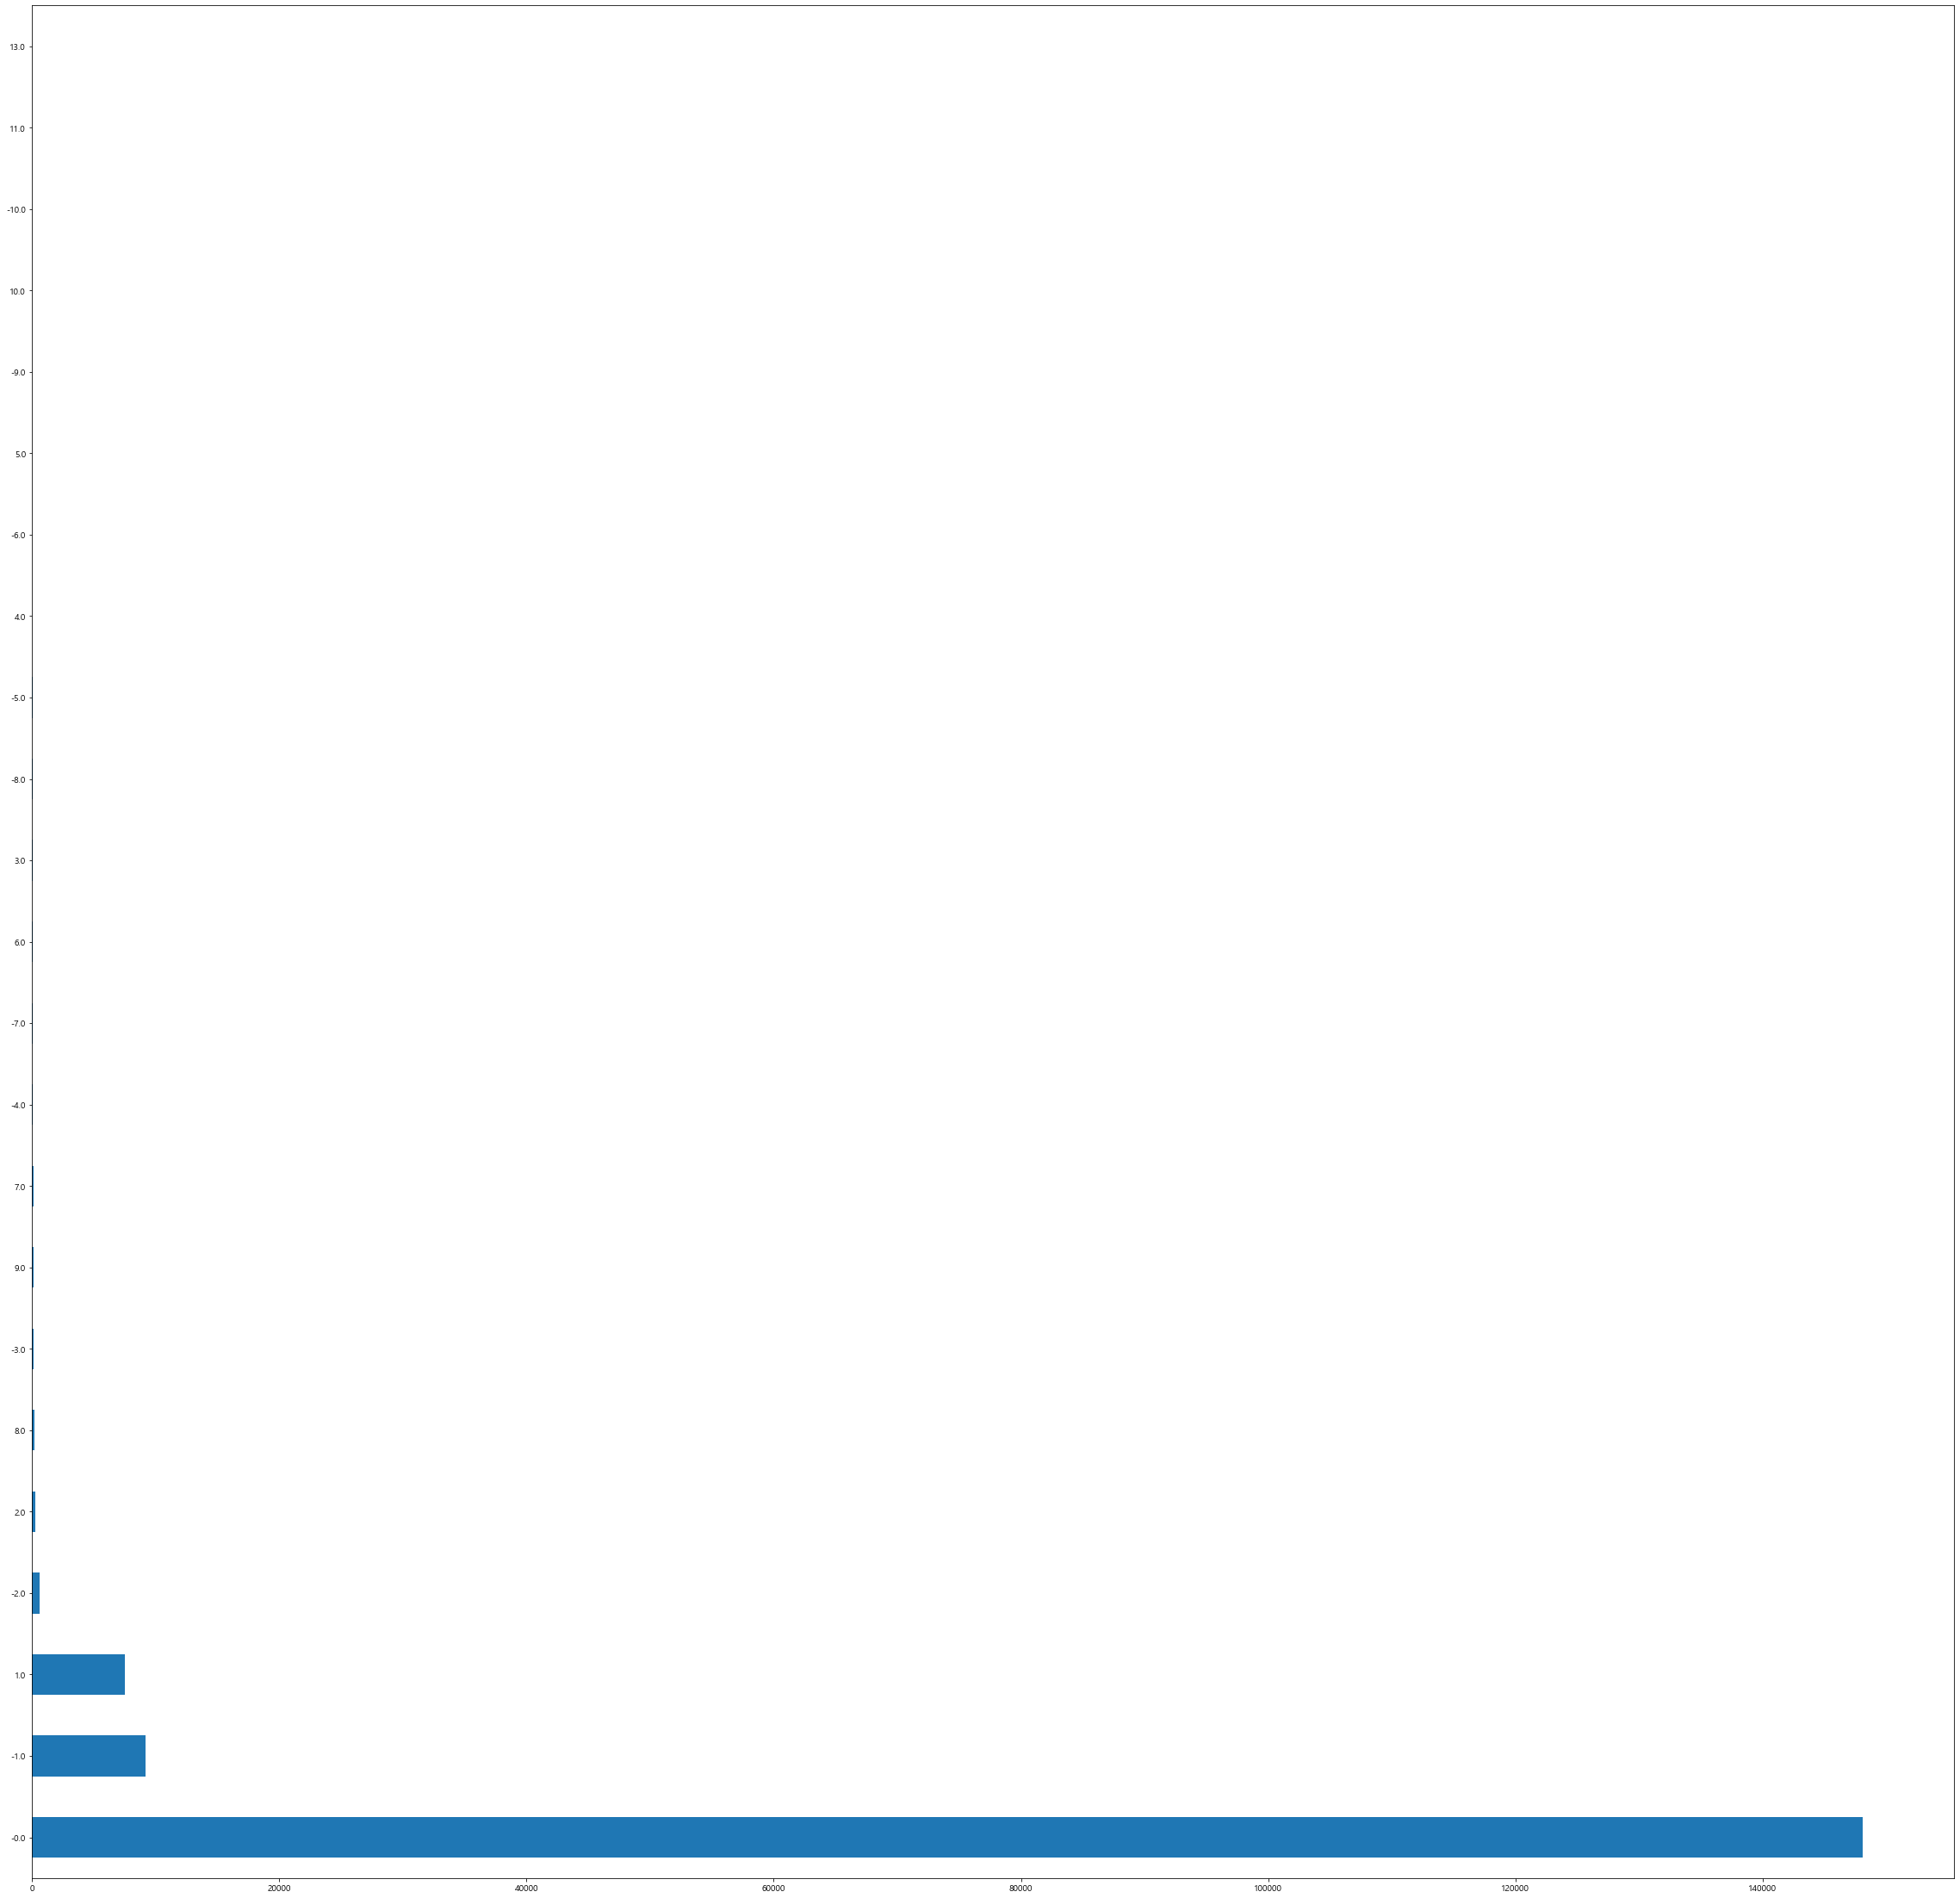

In [250]:
plt.figure(figsize=(40, 40))
df_test['diff_int'].value_counts().plot(kind='barh')
# plt.savefig('./output/png/숙취나이_결측치제거_20대_남자.png')

In [251]:
df_test['diff_int'].value_counts(ascending=False)

-0.0     148078
-1.0       9200
 1.0       7487
-2.0        615
 2.0        268
 8.0        217
-3.0        137
 9.0        129
 7.0        106
-4.0         54
-7.0         52
 6.0         50
 3.0         42
-8.0         41
-5.0         31
 4.0         22
-6.0         22
 5.0         19
-9.0         17
 10.0        14
-10.0         7
 11.0         1
 13.0         1
Name: diff_int, dtype: int64

In [252]:
df_test['예측지수'].round(0).value_counts()

100.0    8482
99.0     6000
101.0    5434
98.0     4724
102.0    4581
103.0    4409
95.0     4259
97.0     4219
105.0    4035
96.0     3864
104.0    3737
106.0    3570
94.0     3462
92.0     3205
108.0    3097
90.0     2917
110.0    2837
112.0    2785
111.0    2664
109.0    2660
88.0     2643
91.0     2634
89.0     2504
107.0    2462
93.0     2401
114.0    2096
87.0     2038
86.0     1993
113.0    1934
83.0     1929
118.0    1910
117.0    1845
80.0     1808
82.0     1800
115.0    1781
120.0    1772
85.0     1766
122.0    1693
78.0     1662
81.0     1649
119.0    1590
84.0     1572
116.0    1554
123.0    1511
77.0     1480
79.0     1478
121.0    1472
76.0     1410
124.0    1342
128.0    1297
75.0     1223
74.0     1214
72.0     1183
125.0    1165
126.0    1120
69.0     1093
127.0    1092
131.0    1053
68.0     1046
73.0     1036
132.0    1027
129.0     908
71.0      889
133.0     839
134.0     804
67.0      799
137.0     797
130.0     777
66.0      754
63.0      737
70.0      727
136.0 

# 예측 나이 분포

In [253]:
if pyTorch_bool:
    # Get predictions
    with torch.no_grad():
        model.eval()
        X_train_pred = model(X_train)
        X_train_pred = X_train_pred.numpy()

    df_train = pd.DataFrame(X_train_pred).reset_index(drop=True)
    y_test = pd.DataFrame(y_test.numpy())

In [254]:
if XGB_bool:
    df_train = pd.DataFrame(model.predict(X_train)).reset_index(drop=True)

In [255]:
# df_test = pd.DataFrame(model.predict(X_test)).reset_index(drop=True)

In [256]:
df_plot = pd.DataFrame(y_test.value_counts())

In [257]:
df_plot.columns = ['count']

In [258]:
df_plot.reset_index(inplace=True)

In [259]:
df_plot = df_plot.sort_values('index', ascending=True)

In [260]:
df_plot

,index,count
95,52.0,14
93,53.0,51
92,54.0,90
89,55.0,263
88,56.0,411
86,57.0,451
80,58.0,516
85,59.0,462
82,60.0,492
75,61.0,579


In [261]:
df_plot.set_index('index', inplace=True)

<AxesSubplot:xlabel='index'>

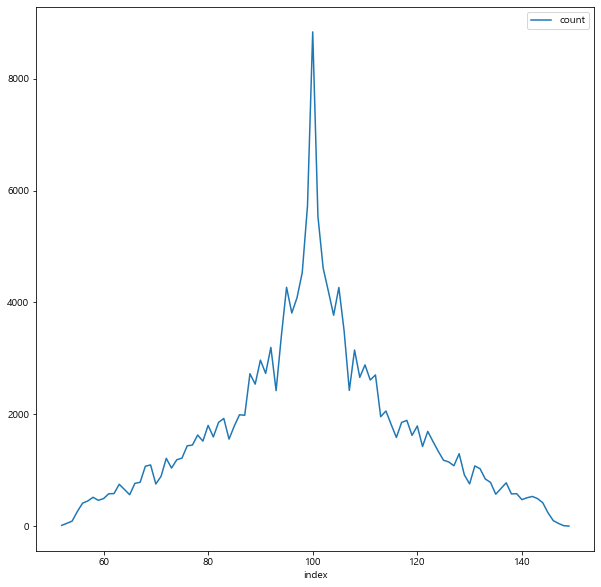

In [262]:
df_plot.plot()

In [263]:
if pyTorch_bool:
    # Get predictions
    with torch.no_grad():
        model.eval()
        X_test_pred = model(X_test)
        X_test_pred = X_test_pred.numpy()
    df_test = pd.DataFrame(X_test_pred).reset_index(drop=True)

In [264]:
if XGB_bool:
    df_test = pd.DataFrame(model.predict(X_test)).reset_index(drop=True)

In [265]:
df_plot = pd.DataFrame(df_test.round(0).value_counts())

In [266]:
df_plot.columns = ['count']

In [267]:
df_plot.reset_index(inplace=True)

In [268]:
df_plot = df_plot.sort_values(0, ascending=True)

In [269]:
df_plot.set_index(0, inplace=True)

In [270]:
df_plot

,count
0,
51.0,1
52.0,18
53.0,47
54.0,93
55.0,260
56.0,400
57.0,444
58.0,538
59.0,452


<AxesSubplot:xlabel='0'>

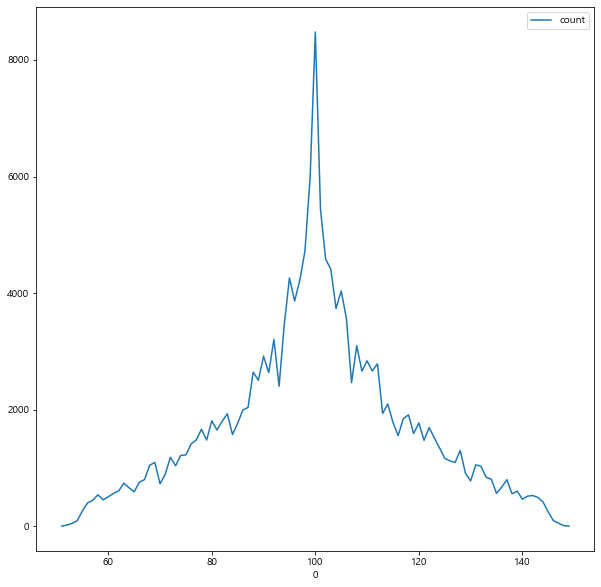

In [271]:
df_plot.plot()

# 시각화

In [272]:
# model.coef_

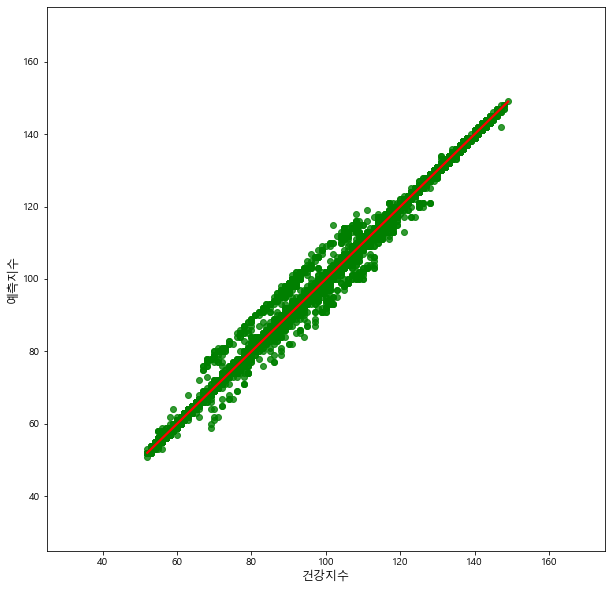

In [273]:
plt.rcParams["figure.figsize"] = (10, 10)
df_scatter = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), df_test.round(0)], axis = 1)
df_scatter.columns = ['건강지수', '예측지수']

import seaborn as sns

# plt.figure(figsize=(10, 10))
# plt.scatter(df_scatterx='나이', y='예측나이', s=9, cmap='Reds', color='green', trendline="ols")
# plt.colorbar()
# sns.scatterplot(x=df_scatter['나이'], y=df_scatter['예측나이'], color='green')
sns.regplot(x=df_scatter['건강지수'], y=df_scatter['예측지수'], scatter_kws={'color':'green'}, line_kws={'color':'red'})
plt.xlabel('건강지수', fontsize=12)
plt.ylabel('예측지수', fontsize=12)
plt.xlim([25, 175])
plt.ylim([25, 175])
plt.show()

# 남성 데이터 전체 계산

In [274]:
df_man.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
0,2011,32,11757,1,24,1.10,0.25,0.63,66.22,100.00,100.00,83.11,92.0
1,2019,50,356493,1,53,0.90,0.20,0.70,99.39,101.31,95.79,98.97,99.0
2,2021,50,642497,1,55,0.90,0.10,0.80,95.61,184.13,70.95,111.58,106.0
3,2019,62,421626,1,40,0.97,0.20,0.77,79.00,100.00,65.70,80.92,90.0
4,2020,62,565527,1,41,0.93,0.20,0.73,83.97,100.00,73.21,85.29,93.0


In [275]:
df_man.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532765 entries, 0 to 532764
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   검진년도        532765 non-null  int64  
 1   UID         532765 non-null  int64  
 2   CU_REC_ID   532765 non-null  int64  
 3   SEX         532765 non-null  int64  
 4   검진당시나이      532765 non-null  int64  
 5   총빌리루빈       532765 non-null  float64
 6   직접빌리루빈      532765 non-null  float64
 7   간접빌리루빈      532765 non-null  float64
 8   총빌리루빈_kde   532765 non-null  float64
 9   직접빌리루빈_kde  532765 non-null  float64
 10  간접빌리루빈_kde  532765 non-null  float64
 11  kde_mean    532765 non-null  float64
 12  target      532765 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 52.8 MB


In [276]:
df_man[df_man['UID'] == 168996]

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
82817,2022,168996,2259500,1,35,0.9,0.3,0.6,93.86,72.52,97.64,89.47,95.0
82818,2023,168996,2259499,1,36,1.1,0.4,0.7,55.17,28.25,76.26,53.71,77.0


In [277]:
train_columns

['검진당시나이', '총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [278]:
if scaling_bool:
    df_pred = df_man_scaled.copy()
else:
    df_pred = df_man.copy()

In [279]:
len(df_pred)

532765

In [280]:
df_pred.reset_index(drop=True, inplace=True)

In [281]:
X_test

,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
8796,48,1.05,0.14,0.63
449886,60,0.50,0.10,0.40
257099,52,0.50,0.20,0.30
34644,55,0.60,0.20,0.40
432959,53,0.60,0.20,0.40
...,...,...,...,...
172697,39,0.32,0.17,0.63
185030,22,0.40,0.10,0.30
256897,54,1.10,0.30,0.80
516501,38,0.70,0.25,0.63


In [282]:
df_pred.columns

Index(['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이', '총빌리루빈', '직접빌리루빈',
       '간접빌리루빈', '총빌리루빈_kde', '직접빌리루빈_kde', '간접빌리루빈_kde', 'kde_mean',
       'target'],
      dtype='object')

In [283]:
df_pred[train_columns]

,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
0,24,1.10,0.25,0.63
1,53,0.90,0.20,0.70
2,55,0.90,0.10,0.80
3,40,0.97,0.20,0.77
4,41,0.93,0.20,0.73
...,...,...,...,...
532760,36,0.70,0.20,0.50
532761,65,0.50,0.20,0.30
532762,29,1.00,0.30,0.70
532763,26,0.90,0.30,0.60


In [284]:
if pyTorch_bool:
    # Get predictions
    with torch.no_grad():
        model.eval()
        pred_data = model(torch.Tensor(df_pred[train_columns].to_numpy()))
        pred_data = pred_data.numpy()

In [285]:
if XGB_bool:
    # Get predictions
    # pred_data = model.predict(df_pred[train_columns])
    pred_data = model.predict(df_pred[train_columns])

In [286]:
pred_data = pred_data.round(0)

In [287]:
pred_data

array([ 92.,  99., 106., ...,  94.,  97.,  96.], dtype=float32)

In [288]:
df_output = pd.concat([df_pred, pd.DataFrame(pred_data, columns=['예측지수']).reset_index(drop=True)], axis=1)

In [289]:
if scaling_bool:
    df_output = pd.concat([df_man[['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이']], df_output], axis=1)

In [290]:
df_output.head(20)

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target,예측지수
0,2011,32,11757,1,24,1.10,0.25,0.63,66.22,100.00,100.00,83.11,92.0,92.0
1,2019,50,356493,1,53,0.90,0.20,0.70,99.39,101.31,95.79,98.97,99.0,99.0
2,2021,50,642497,1,55,0.90,0.10,0.80,95.61,184.13,70.95,111.58,106.0,106.0
3,2019,62,421626,1,40,0.97,0.20,0.77,79.00,100.00,65.70,80.92,90.0,90.0
4,2020,62,565527,1,41,0.93,0.20,0.73,83.97,100.00,73.21,85.29,93.0,92.0
5,2021,62,699357,1,42,1.01,0.22,0.79,76.93,66.95,65.69,71.62,86.0,86.0
6,2022,62,1356310,1,43,0.86,0.26,0.60,93.73,26.80,95.62,77.47,89.0,89.0
7,2023,62,2170394,1,44,1.10,0.30,0.74,55.55,86.81,67.96,66.47,83.0,84.0
8,2019,67,410099,1,51,0.54,0.20,0.63,140.43,100.00,100.00,120.22,110.0,110.0
9,2020,67,481109,1,52,0.83,0.27,0.63,100.00,39.10,100.00,84.78,92.0,92.0


## 예측지수 성능평가

In [291]:
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
mean_absolute_error(df_output['target'], df_output['예측지수'])

0.15656058487325555

# target으로 나이 계산

In [292]:
df_output['예측나이'] = ((100 - df_output['예측지수']) / 5) + df_output['검진당시나이']
df_output['예측나이'] = df_output['예측나이'].round(2)

In [293]:
df_output.head(30)

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target,예측지수,예측나이
0,2011,32,11757,1,24,1.10,0.25,0.63,66.22,100.00,100.00,83.11,92.0,92.0,25.6
1,2019,50,356493,1,53,0.90,0.20,0.70,99.39,101.31,95.79,98.97,99.0,99.0,53.2
2,2021,50,642497,1,55,0.90,0.10,0.80,95.61,184.13,70.95,111.58,106.0,106.0,53.8
3,2019,62,421626,1,40,0.97,0.20,0.77,79.00,100.00,65.70,80.92,90.0,90.0,42.0
4,2020,62,565527,1,41,0.93,0.20,0.73,83.97,100.00,73.21,85.29,93.0,92.0,42.6
5,2021,62,699357,1,42,1.01,0.22,0.79,76.93,66.95,65.69,71.62,86.0,86.0,44.8
6,2022,62,1356310,1,43,0.86,0.26,0.60,93.73,26.80,95.62,77.47,89.0,89.0,45.2
7,2023,62,2170394,1,44,1.10,0.30,0.74,55.55,86.81,67.96,66.47,83.0,84.0,47.2
8,2019,67,410099,1,51,0.54,0.20,0.63,140.43,100.00,100.00,120.22,110.0,110.0,49.0
9,2020,67,481109,1,52,0.83,0.27,0.63,100.00,39.10,100.00,84.78,92.0,92.0,53.6


## 예측나이 성능평가

In [294]:
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
mean_absolute_error(df_output['검진당시나이'], df_output['예측나이'])

2.5595363809559566

# 최종 산출

In [295]:
df_output.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target,예측지수,예측나이
0,2011,32,11757,1,24,1.10,0.25,0.63,66.22,100.00,100.00,83.11,92.0,92.0,25.6
1,2019,50,356493,1,53,0.90,0.20,0.70,99.39,101.31,95.79,98.97,99.0,99.0,53.2
2,2021,50,642497,1,55,0.90,0.10,0.80,95.61,184.13,70.95,111.58,106.0,106.0,53.8
3,2019,62,421626,1,40,0.97,0.20,0.77,79.00,100.00,65.70,80.92,90.0,90.0,42.0
4,2020,62,565527,1,41,0.93,0.20,0.73,83.97,100.00,73.21,85.29,93.0,92.0,42.6


# DataMart csv

In [296]:
df_copy = df.copy()

In [297]:
df_copy.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
0,2010,7282,2520,1,42,1.7,0.3,NaN
1,2010,7490,3638,1,39,0.9,0.3,0.6
2,2010,7915,3997,1,36,1.4,NaN,NaN
3,2010,8056,4745,1,42,0.7,0.2,NaN
4,2010,8457,3929,1,38,1.9,NaN,NaN


In [298]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213899 entries, 0 to 1213898
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   검진년도       1213899 non-null  int64  
 1   UID        1213899 non-null  int64  
 2   CU_REC_ID  1213899 non-null  int64  
 3   SEX        1213899 non-null  int64  
 4   검진당시나이     1213899 non-null  int64  
 5   총빌리루빈      1109378 non-null  float64
 6   직접빌리루빈     1040148 non-null  float64
 7   간접빌리루빈     822450 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 74.1 MB


In [299]:
minimums

[-0.12000000000000022, 0.050000000000000044, -0.20000000000000007]

In [300]:
maximums

[1.8000000000000003, 0.44999999999999996, 1.4000000000000001]

In [301]:
train_columns

['검진당시나이', '총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [302]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [303]:
for idx, col in enumerate(target_cols):    
    df_copy.loc[df_copy[col] < minimums[idx], col] = minimums[idx]
    df_copy.loc[df_copy[col] > maximums[idx], col] = maximums[idx]

In [304]:
df_man_csv = df_copy[df_copy['SEX'] == 1]
len(df_man_csv)

765459

In [305]:
df_man_csv.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
0,2010,7282,2520,1,42,1.7,0.3,NaN
1,2010,7490,3638,1,39,0.9,0.3,0.6
2,2010,7915,3997,1,36,1.4,NaN,NaN
3,2010,8056,4745,1,42,0.7,0.2,NaN
4,2010,8457,3929,1,38,1.8,NaN,NaN


## 검진 항목 all 결측치 지우기

In [306]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [307]:
df_man_csv.dropna(subset=target_cols, how='all', inplace=True)

In [308]:
df_man_csv.reset_index(drop=True, inplace=True)

In [309]:
len(df_man_csv)

703698

## fillna

In [310]:
df_man_csv.fillna(df_man.mean().round(2), inplace=True)

## 스크리닝

In [311]:
# screening = 80

In [312]:
# df_man_csv[df_man_csv['ALP'] < screening].head()

In [313]:
# len(df_man_csv[df_man_csv['ALP'] < screening])

In [314]:
# df_man_csv.loc[df_man_csv['ALP'] < screening, 'ALP'] = screening

In [315]:
# df_man_csv[df_man_csv['ALP'] < screening].head()

In [316]:
# len(df_man_csv[df_man_csv['ALP'] < screening])

In [317]:
# len(df_man_csv)

## 모델 예측

In [318]:
if XGB_bool:
    # Get predictions
    # pred_data = model.predict(df_pred[train_columns])
    pred_data = model.predict(df_man_csv[train_columns])

In [319]:
pred_data = pred_data.round(0)

In [320]:
df_man_csv = pd.concat([df_man_csv, pd.DataFrame(pred_data, columns=['예측지수']).reset_index(drop=True)], axis=1)

In [321]:
df_man_csv.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수
0,2010,7282,2520,1,42,1.7,0.30,0.63,74.0
1,2010,7490,3638,1,39,0.9,0.30,0.60,95.0
2,2010,7915,3997,1,36,1.4,0.25,0.63,80.0
3,2010,8056,4745,1,42,0.7,0.20,0.63,102.0
4,2010,8457,3929,1,38,1.8,0.25,0.63,76.0


### 성능 평가

In [322]:
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
# print('MAE :',mean_absolute_error(df_man_csv['target'], df_man_csv['예측지수']))

In [323]:
# r2_score(df_man_csv['target'], df_man_csv['예측지수'])

## 예측나이 계산

In [324]:
df_man_csv['예측나이'] = ((100 - df_man_csv['예측지수']) / 5) + df_man_csv['검진당시나이']
df_man_csv['예측나이'] = df_man_csv['예측나이'].round(2)

### 성능 평가

In [325]:
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
print('MAE :',mean_absolute_error(df_man_csv['검진당시나이'], df_man_csv['예측나이']))

MAE : 3.0056797091934326


In [326]:
r2_score(df_man_csv['검진당시나이'], df_man_csv['예측나이'])

0.7942160369548962

In [327]:
df_man_csv.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
0,2010,7282,2520,1,42,1.7,0.30,0.63,74.0,47.2
1,2010,7490,3638,1,39,0.9,0.30,0.60,95.0,40.0
2,2010,7915,3997,1,36,1.4,0.25,0.63,80.0,40.0
3,2010,8056,4745,1,42,0.7,0.20,0.63,102.0,41.6
4,2010,8457,3929,1,38,1.8,0.25,0.63,76.0,42.8


In [328]:
df_man_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703698 entries, 0 to 703697
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   검진년도       703698 non-null  int64  
 1   UID        703698 non-null  int64  
 2   CU_REC_ID  703698 non-null  int64  
 3   SEX        703698 non-null  int64  
 4   검진당시나이     703698 non-null  int64  
 5   총빌리루빈      703698 non-null  float64
 6   직접빌리루빈     703698 non-null  float64
 7   간접빌리루빈     703698 non-null  float64
 8   예측지수       703698 non-null  float32
 9   예측나이       703698 non-null  float64
dtypes: float32(1), float64(4), int64(5)
memory usage: 51.0 MB


# 최종 UID별 확인

In [329]:
# 김태현 본부장님
df_man_csv[df_man_csv['UID'] == 175673].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
252350,2022,175673,751348,1,48,0.7,0.2,0.5,103.0,47.4
252351,2022,175673,1463838,1,48,0.7,0.2,0.5,103.0,47.4
252287,2022,175673,1919125,1,48,0.7,0.2,0.5,103.0,47.4
252352,2022,175673,2169120,1,48,0.7,0.2,0.5,103.0,47.4
252288,2022,175673,2223795,1,48,0.7,0.2,0.5,103.0,47.4
252289,2022,175673,2237465,1,48,0.7,0.2,0.5,103.0,47.4
252353,2022,175673,2238320,1,48,0.7,0.2,0.5,103.0,47.4
252354,2022,175673,2246042,1,48,0.7,0.2,0.5,103.0,47.4
412254,2023,175673,1463893,1,49,0.6,0.2,0.4,112.0,46.6
412250,2023,175673,1919126,1,49,0.6,0.2,0.4,112.0,46.6


In [330]:
# 양원영 유닛장님
df_man_csv[df_man_csv['UID'] == 289587].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
179281,2021,289587,796178,1,47,1.2,0.4,0.8,76.0,51.8
283388,2022,289587,866076,1,48,0.8,0.3,0.5,99.0,48.2
283343,2022,289587,2115999,1,48,0.8,0.3,0.5,99.0,48.2
87993,2022,289587,2603574,1,48,0.8,0.3,0.5,99.0,48.2
461004,2023,289587,1487447,1,49,0.5,0.2,0.3,122.0,44.6
461005,2023,289587,2227964,1,49,0.5,0.2,0.3,122.0,44.6
640377,2024,289587,2243723,1,50,0.4,0.2,0.2,127.0,44.6
640355,2024,289587,2603575,1,50,0.4,0.2,0.2,127.0,44.6


In [331]:
# 한...
df_man_csv[df_man_csv['UID'] == 897603].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
382574,2022,897603,1066133,1,51,0.7,0.3,0.4,104.0,50.2
382585,2022,897603,1068885,1,51,0.7,0.3,0.4,104.0,50.2
382586,2022,897603,1728532,1,51,0.7,0.3,0.4,104.0,50.2
382587,2022,897603,2555144,1,51,0.7,0.3,0.4,104.0,50.2
551740,2023,897603,1458387,1,52,0.6,0.2,0.4,111.0,49.8
551741,2023,897603,1728531,1,52,0.6,0.2,0.4,111.0,49.8
540436,2023,897603,2120063,1,52,0.6,0.2,0.4,111.0,49.8
540437,2023,897603,2351665,1,52,0.6,0.2,0.4,111.0,49.8
551742,2023,897603,2555143,1,52,0.6,0.2,0.4,111.0,49.8
540438,2023,897603,2622260,1,52,0.6,0.2,0.4,111.0,49.8


In [332]:
# 김명근 팀장님
df_man_csv[df_man_csv['UID'] == 119172].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
236929,2022,119172,751336,1,41,1.0,0.4,0.6,85.0,44.0
236930,2022,119172,1432355,1,41,1.0,0.4,0.6,85.0,44.0
236927,2022,119172,1432476,1,41,1.0,0.4,0.6,85.0,44.0
236931,2022,119172,2247083,1,41,1.0,0.4,0.6,85.0,44.0
236932,2022,119172,2252956,1,41,1.0,0.4,0.6,85.0,44.0
398265,2023,119172,1436742,1,42,0.9,0.3,0.6,95.0,43.0
398266,2023,119172,2247082,1,42,0.9,0.3,0.6,95.0,43.0
398267,2023,119172,2252955,1,42,0.9,0.3,0.6,95.0,43.0
622051,2024,119172,2250063,1,43,0.7,0.3,0.4,102.0,42.6
622052,2024,119172,2252954,1,43,0.7,0.3,0.4,102.0,42.6


In [333]:
# 성주용
df_man_csv[df_man_csv['UID'] == 897595].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
551735,2023,897595,1525045,1,40,0.3,0.2,0.1,135.0,33.0
551736,2023,897595,1593851,1,40,0.3,0.2,0.1,135.0,33.0
551733,2023,897595,2005289,1,40,0.3,0.2,0.1,135.0,33.0
551734,2023,897595,2138998,1,40,0.3,0.2,0.1,135.0,33.0
536065,2023,897595,2320478,1,40,0.3,0.2,0.1,135.0,33.0
551737,2023,897595,2328772,1,40,0.3,0.2,0.1,135.0,33.0
682112,2024,897595,2329051,1,41,0.8,0.3,0.5,98.0,41.4


In [334]:
# 최재..
df_man_csv[df_man_csv['UID'] == 492764].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
331602,2022,492764,909688,1,39,1.0,0.4,0.6,84.0,42.2
331603,2022,492764,1575802,1,39,1.0,0.4,0.6,84.0,42.2
331606,2022,492764,1668547,1,39,1.0,0.4,0.6,84.0,42.2
331604,2022,492764,2246777,1,39,1.0,0.4,0.6,84.0,42.2
331605,2022,492764,2330256,1,39,1.0,0.4,0.6,84.0,42.2
132770,2022,492764,2343199,1,39,1.0,0.4,0.6,84.0,42.2
149938,2022,492764,2363393,1,39,1.0,0.4,0.6,84.0,42.2
149939,2022,492764,2639564,1,39,1.0,0.4,0.6,84.0,42.2
149940,2022,492764,2703924,1,39,1.0,0.4,0.6,84.0,42.2
331607,2022,492764,2783328,1,39,1.0,0.4,0.6,84.0,42.2


In [335]:
# 장경..
df_man_csv[df_man_csv['UID'] == 933936].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
555920,2023,933936,1431742,1,40,1.0,0.3,0.7,89.0,42.2
555921,2023,933936,1435266,1,40,1.0,0.3,0.7,89.0,42.2
683402,2024,933936,2242997,1,41,0.8,0.3,0.5,98.0,41.4


In [336]:
df_man_csv[df_man_csv['UID'] == 168996].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
249911,2022,168996,919754,1,35,0.9,0.30,0.6,95.0,36.0
249912,2022,168996,1425925,1,35,0.9,0.30,0.6,95.0,36.0
249913,2022,168996,2259500,1,35,0.9,0.30,0.6,95.0,36.0
410015,2023,168996,1425970,1,36,1.1,0.40,0.7,77.0,40.6
410016,2023,168996,1475832,1,36,1.1,0.40,0.7,77.0,40.6
410017,2023,168996,2259499,1,36,1.1,0.40,0.7,77.0,40.6
627245,2024,168996,2281994,1,37,1.2,0.45,0.7,74.0,42.2


# 여성 모델

In [337]:
df_target['SEX'].value_counts()

1    686726
2    428854
Name: SEX, dtype: int64

In [338]:
df_woman = df_target[df_target['SEX'] == 2]
len(df_woman)

428854

# 결측치 처리

## 결측치 삭제

In [339]:
# df_woman.dropna(inplace=True)

In [340]:
df_woman.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
727811,2010,710490,213,2,28,0.7,0.2,NaN,90.59,100.00,100.0,95.30,98.0
690087,2010,315847,230,2,23,0.8,0.2,NaN,73.54,100.00,100.0,86.77,93.0
692391,2010,719072,231,2,24,0.5,0.1,NaN,102.54,165.17,100.0,117.56,109.0
947870,2010,552037,332,2,41,0.5,0.1,NaN,115.54,159.22,100.0,122.58,111.0
789956,2010,232950,983,2,32,1.2,0.2,NaN,19.69,100.00,100.0,59.84,80.0


## 결측치 평균으로 대체

In [341]:
# 결측치를 평균으로 대체 하는 함수
fill_mean_func = lambda g: g.fillna(g.mean().round(2))

In [342]:
# 나이로 group by, 결측치를 평균으로 대체
# df_woman = df_woman.groupby('검진당시나이').apply(fill_mean_func)

## 검진 항목 all 결측치 지우기

In [343]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [344]:
len(df_woman)

428854

In [345]:
df_woman.dropna(subset=target_cols, how='all', inplace=True)

In [346]:
len(df_woman)

387016

In [347]:
df_woman.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
727811,2010,710490,213,2,28,0.7,0.2,NaN,90.59,100.00,100.0,95.30,98.0
690087,2010,315847,230,2,23,0.8,0.2,NaN,73.54,100.00,100.0,86.77,93.0
692391,2010,719072,231,2,24,0.5,0.1,NaN,102.54,165.17,100.0,117.56,109.0
947870,2010,552037,332,2,41,0.5,0.1,NaN,115.54,159.22,100.0,122.58,111.0
789956,2010,232950,983,2,32,1.2,0.2,NaN,19.69,100.00,100.0,59.84,80.0


In [348]:
len(df_woman)

387016

## fillna

In [349]:
df_woman.mean().round(2)

검진년도             2021.94
UID            488888.88
CU_REC_ID     1465137.46
SEX                 2.00
검진당시나이             38.73
총빌리루빈               0.72
직접빌리루빈              0.22
간접빌리루빈              0.51
총빌리루빈_kde          88.68
직접빌리루빈_kde         94.14
간접빌리루빈_kde         92.66
kde_mean           91.04
target             95.52
dtype: float64

In [350]:
df_woman.fillna(df_woman.mean().round(2), inplace=True)

In [351]:
# df_woman.fillna(0, inplace=True)

## IterativeImputer

In [352]:
# df_impute = pd.DataFrame(IterativeImputer(random_state=87).fit_transform(df_woman))
# df_impute.columns = df_woman.columns
# df_target = df_impute

## MICE(Multivariate Imputation by Chained Equation) Imputation

In [353]:
# import time
# start = time.time()
# np_imputed = mice(df_woman.values) # mice 학습시작
# df_woman = pd.DataFrame(np_imputed)
# end = time.time()
# print(f"{end - start:.5f} sec")

In [354]:
df_woman.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
727811,2010,710490,213,2,28,0.7,0.2,0.51,90.59,100.00,100.0,95.30,98.0
690087,2010,315847,230,2,23,0.8,0.2,0.51,73.54,100.00,100.0,86.77,93.0
692391,2010,719072,231,2,24,0.5,0.1,0.51,102.54,165.17,100.0,117.56,109.0
947870,2010,552037,332,2,41,0.5,0.1,0.51,115.54,159.22,100.0,122.58,111.0
789956,2010,232950,983,2,32,1.2,0.2,0.51,19.69,100.00,100.0,59.84,80.0


# 스크리닝

## 간접빌리루빈 스크리닝

In [355]:
screening = 0

In [356]:
df_woman[df_woman['간접빌리루빈'] < screening].head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target


In [357]:
len(df_woman[df_woman['간접빌리루빈'] < screening])

0

In [358]:
df_woman.loc[df_woman['간접빌리루빈'] < screening, '간접빌리루빈'] = screening

In [359]:
df_woman[df_woman['간접빌리루빈'] < screening].head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target


In [360]:
len(df_woman[df_woman['간접빌리루빈'] < screening])

0

# 중복 제거

In [361]:
len(df_woman)

387016

In [362]:
# 동일한 검진년도에 중복건을 제외하기 위해서 sort value 한다음 중복시 첫 번째것만 남겨둠
df_woman.sort_values(by=['UID', '검진년도', 'CU_REC_ID'], ascending=[True, True, False], inplace=True)

In [363]:
df_woman.head(20)

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
707460,2021,53,2632765,2,26,0.60,0.20,0.40,100.96,100.00,100.16,100.52,100.0
707459,2021,53,664316,2,26,0.60,0.20,0.40,100.96,100.00,100.16,100.52,100.0
755622,2024,53,2658222,2,29,0.50,0.20,0.30,108.77,100.00,116.24,108.44,104.0
759521,2020,54,497669,2,30,0.76,0.07,0.69,91.33,184.53,50.51,104.42,102.0
796638,2022,54,1319859,2,32,0.80,0.20,0.60,84.79,100.00,65.78,83.84,92.0
815783,2023,54,2039511,2,33,0.70,0.10,0.60,91.62,153.11,70.03,101.60,101.0
837713,2024,54,2750990,2,34,0.82,0.14,0.68,70.22,180.29,46.70,91.86,96.0
812789,2022,56,1351361,2,33,1.10,0.30,0.80,28.69,57.73,29.34,36.11,68.0
812788,2022,56,1019732,2,33,1.10,0.30,0.80,28.69,57.73,29.34,36.11,68.0
832724,2023,56,2032999,2,34,1.20,0.30,0.90,15.10,54.39,13.41,24.50,62.0


## first만 남겨두고 중복 제거

In [364]:
df_woman = df_woman.drop_duplicates(subset=['UID', '검진년도'], keep='first')

In [365]:
df_woman.reset_index(drop=True, inplace=True)

In [366]:
df_woman.head(20)

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
0,2021,53,2632765,2,26,0.60,0.20,0.40,100.96,100.00,100.16,100.52,100.0
1,2024,53,2658222,2,29,0.50,0.20,0.30,108.77,100.00,116.24,108.44,104.0
2,2020,54,497669,2,30,0.76,0.07,0.69,91.33,184.53,50.51,104.42,102.0
3,2022,54,1319859,2,32,0.80,0.20,0.60,84.79,100.00,65.78,83.84,92.0
4,2023,54,2039511,2,33,0.70,0.10,0.60,91.62,153.11,70.03,101.60,101.0
5,2024,54,2750990,2,34,0.82,0.14,0.68,70.22,180.29,46.70,91.86,96.0
6,2022,56,1351361,2,33,1.10,0.30,0.80,28.69,57.73,29.34,36.11,68.0
7,2023,56,2032999,2,34,1.20,0.30,0.90,15.10,54.39,13.41,24.50,62.0
8,2021,59,701026,2,29,0.90,0.20,0.70,60.48,100.00,47.70,67.16,84.0
9,2022,59,1376992,2,30,0.90,0.30,0.60,60.87,51.25,74.99,62.00,81.0


# 연령별 개수 현황(검진당시나이)

<AxesSubplot:xlabel='index'>

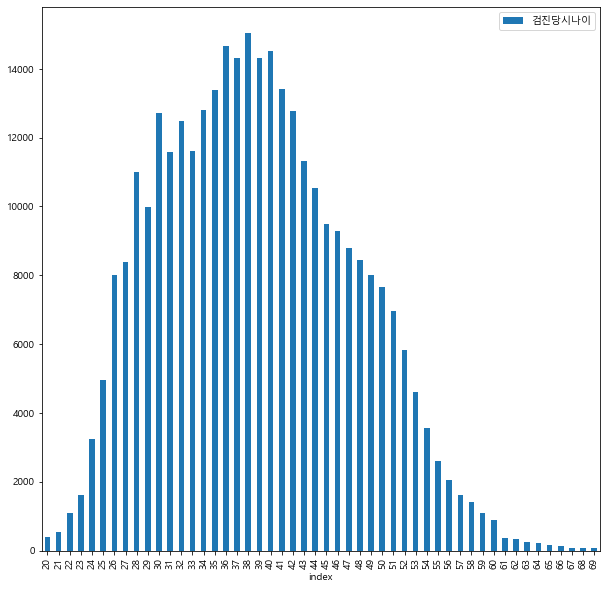

In [367]:
df_woman['검진당시나이'].value_counts().reset_index().sort_values('index').plot.bar(x='index', y='검진당시나이')

In [368]:
df_woman['검진당시나이'].value_counts().reset_index().sort_values('index')

,index,검진당시나이
40,20,394
39,21,552
37,22,1087
33,23,1625
30,24,3248
27,25,4961
23,26,8013
21,27,8387
14,28,10988
16,29,9973


# 검진항목 시각화

In [369]:
df_woman.describe()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
count,328730.000000,3.287300e+05,3.287300e+05,328730.0,328730.000000,328730.000000,328730.000000,328730.000000,328730.000000,328730.000000,328730.000000,328730.000000,328730.000000
mean,2021.886138,4.824180e+05,1.449626e+06,2.0,38.777994,0.729719,0.217320,0.511724,87.849555,94.957506,92.140989,90.699390,95.345201
std,1.578737,3.582909e+05,8.180258e+05,0.0,8.438725,0.268528,0.080627,0.195868,40.605735,48.562262,36.235134,35.863538,17.929162
min,2010.000000,5.300000e+01,2.130000e+02,2.0,20.000000,0.000000,0.060000,0.000000,0.090000,1.670000,0.130000,1.200000,51.000000
25%,2021.000000,2.144112e+05,6.233382e+05,2.0,32.000000,0.520000,0.180000,0.400000,60.480000,52.380000,74.990000,67.600000,84.000000
50%,2022.000000,3.642420e+05,1.365551e+06,2.0,38.000000,0.700000,0.200000,0.510000,95.970000,100.000000,100.000000,94.960000,97.000000
75%,2023.000000,8.011730e+05,2.166125e+06,2.0,45.000000,0.900000,0.300000,0.600000,109.460000,133.900000,101.510000,114.360000,107.000000
max,2024.000000,1.473590e+06,2.871326e+06,2.0,69.000000,1.800000,0.440000,1.400000,199.980000,197.810000,198.880000,196.600000,148.000000


<AxesSubplot:xlabel='검진당시나이'>

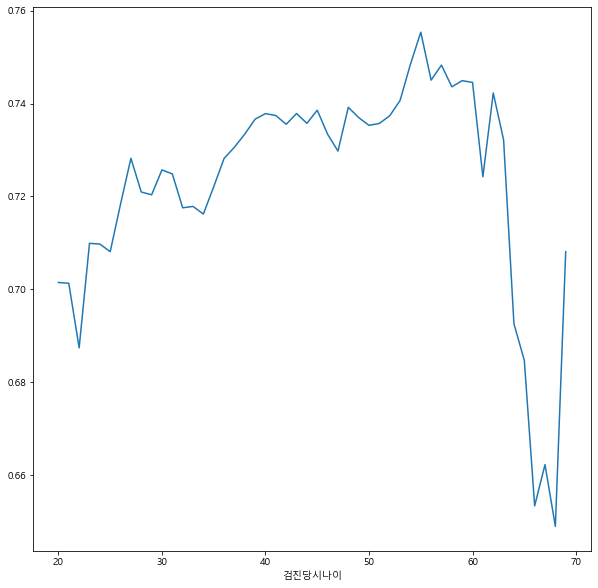

In [370]:
df_woman.groupby('검진당시나이').mean()[target_cols[0]].plot()

<AxesSubplot:xlabel='검진당시나이'>

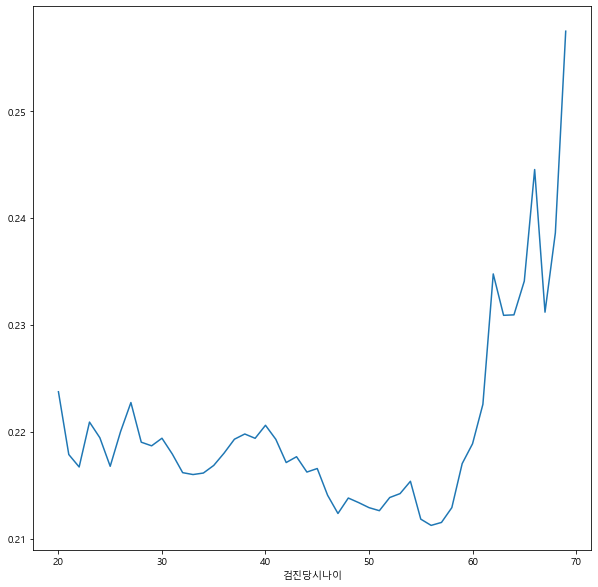

In [371]:
df_woman.groupby('검진당시나이').mean()[target_cols[1]].plot()

<AxesSubplot:xlabel='검진당시나이'>

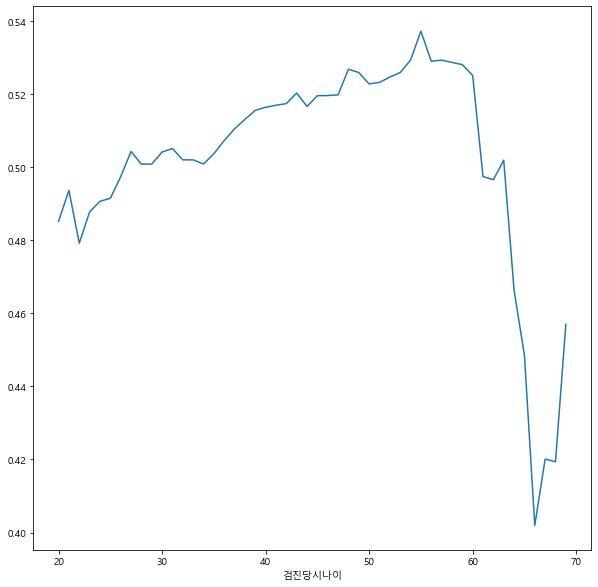

In [372]:
df_woman.groupby('검진당시나이').mean()[target_cols[2]].plot()

<AxesSubplot:xlabel='검진당시나이', ylabel='target'>

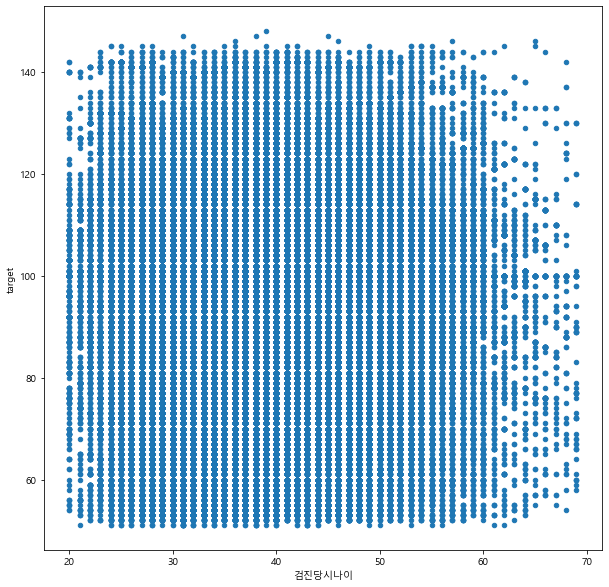

In [373]:
df_woman.plot.scatter(x='검진당시나이', y='target')

# 건강지수 Sampling

<AxesSubplot:xlabel='index'>

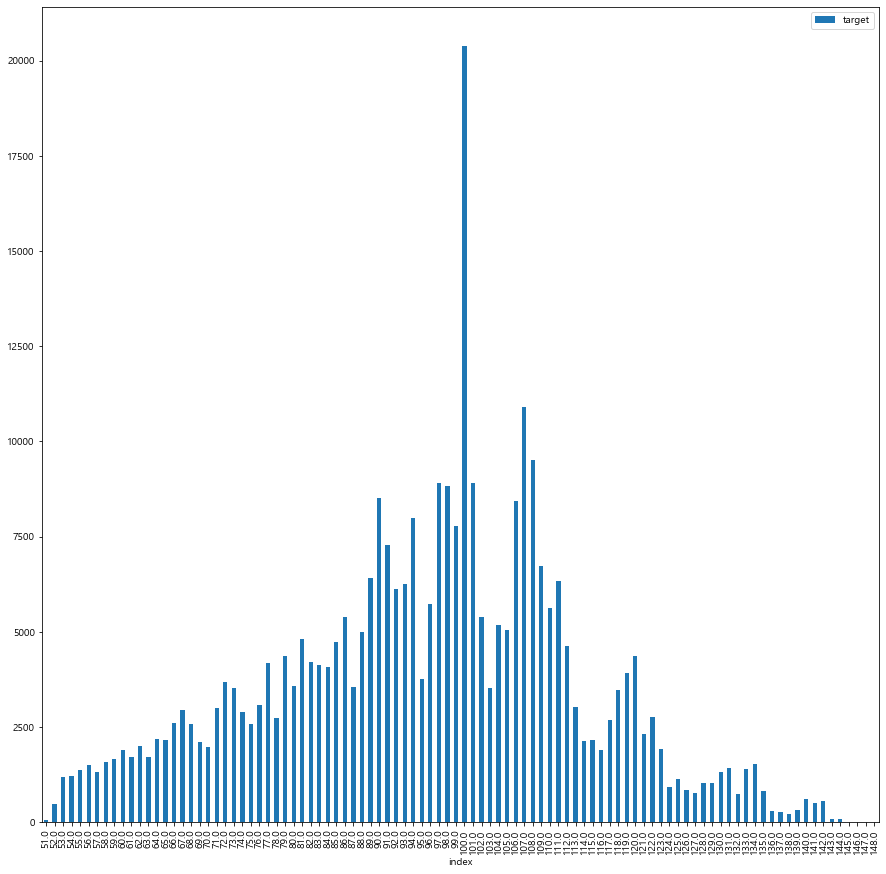

In [374]:
plt.rcParams["figure.figsize"] = (15, 15)
df_woman['target'].value_counts().reset_index().sort_values('index').plot.bar(x='index', y='target')

In [375]:
df_woman['target'].value_counts().reset_index().sort_values('index')

,index,target
93,51.0,64
86,52.0,472
74,53.0,1189
73,54.0,1226
70,55.0,1364
67,56.0,1499
72,57.0,1319
65,58.0,1581
64,59.0,1670
60,60.0,1895


In [376]:
df_woman_sampling = pd.DataFrame()

# for target in range(int(df_woman['target'].min()), 100):
for target in range(50, 100): 
    
#     print(target, 200 - target)
    left_len = len(df_woman[df_woman['target'] == target])
    right_len = len(df_woman[df_woman['target'] == (200 - target)])
    
#     print(target, left_len, right_len)
    
    if left_len >= right_len:
        if left_len > 0:
            df_woman_sampling = pd.concat([df_woman_sampling, df_woman[df_woman['target'] == target].sample(left_len, replace=True, random_state=87)])
        if right_len > 0:
            df_woman_sampling = pd.concat([df_woman_sampling, df_woman[df_woman['target'] == (200 - target)].sample(left_len, replace=True, random_state=87)])
    else:
        if left_len > 0:
            df_woman_sampling = pd.concat([df_woman_sampling, df_woman[df_woman['target'] == target].sample(right_len, replace=True, random_state=87)])
        if right_len > 0:
            df_woman_sampling = pd.concat([df_woman_sampling, df_woman[df_woman['target'] == (200 - target)].sample(right_len, replace=True, random_state=87)])   

df_woman_sampling = pd.concat([df_woman_sampling, df_woman[df_woman['target'] == 100]])                    

In [377]:
# df_woman = df_woman_sampling.copy()

<AxesSubplot:xlabel='index'>

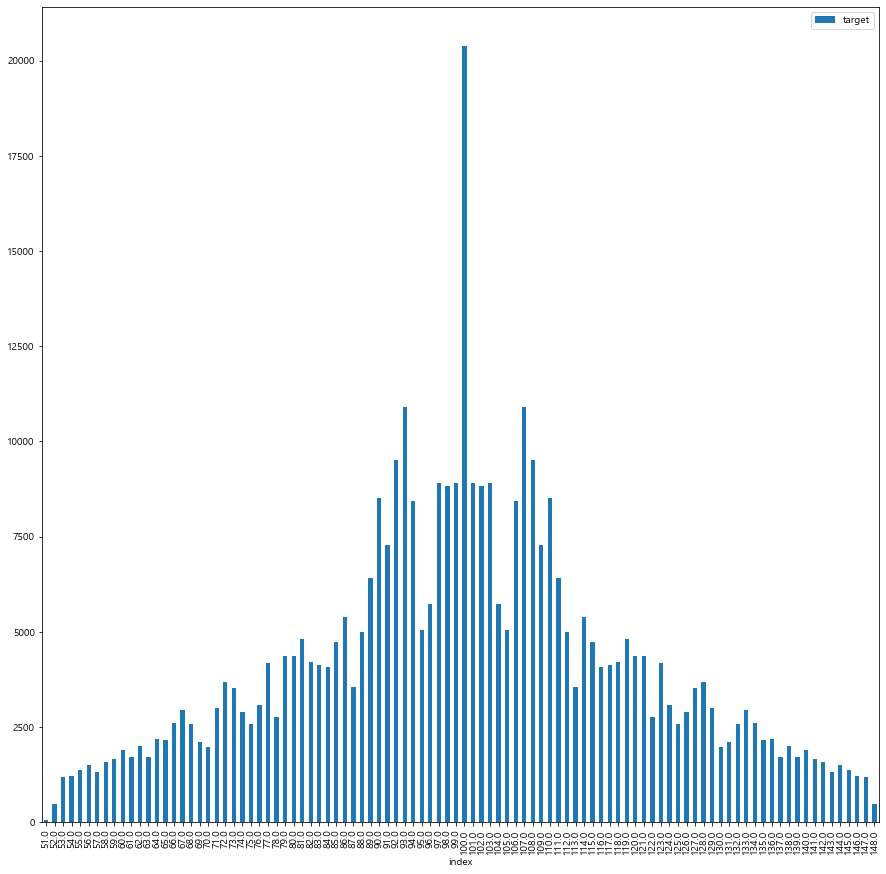

In [378]:
plt.rcParams["figure.figsize"] = (15, 15)
df_woman_sampling['target'].value_counts().reset_index().sort_values('index').plot.bar(x='index', y='target')

In [379]:
df_woman_sampling['target'].value_counts().reset_index().sort_values('index')

,index,target
97,51.0,64
96,52.0,472
94,53.0,1189
92,54.0,1226
87,55.0,1364
85,56.0,1499
89,57.0,1319
84,58.0,1581
82,59.0,1670
75,60.0,1895


# 나이별 확인하기

In [380]:
# df_woman['검진당시나이'].value_counts()

In [381]:
# int(df_woman['검진당시나이'].value_counts().mean())

In [382]:
# df_woman['검진당시나이'].min()

In [383]:
# df_woman['검진당시나이'].max()

In [384]:
# df_woman.columns

In [385]:
# df_temp = None
# # sample_len = int(df_woman['검진당시나이'].value_counts().mean())
# # sample_len = 500
                 
# for age in range(df_woman['검진당시나이'].min(), df_woman['검진당시나이'].max()):
#     temp_ = df_woman[df_woman['검진당시나이'] == age].sample(n = sample_len, replace=True)
# #     df_impute = pd.DataFrame(IterativeImputer(random_state=87).fit_transform(temp))
# #     print(df_impute.columns)
# #     df_impute.columns = df_man.columns
    
# #     np_imputed = mice(temp.values)
# #     np_imputed = fast_knn(temp.values, k=5)
# #     df_impute = pd.DataFrame(np_immputed)
# #     temp = df_impute
    
#     df_temp = pd.concat([df_temp, temp_])

In [386]:
# df_temp.info()

In [387]:
# df_temp.reset_index(drop=True, inplace=True)

In [388]:
# df_woman = df_temp.copy()

In [389]:
# df_woman['검진당시나이'].value_counts()

In [390]:
# df_woman[df_woman['검진당시나이']==20]

In [391]:
# df_woman[df_woman['검진당시나이']==20]['UID'].value_counts()

# model train

In [392]:
# train_columns = ['공복시혈당', '당화혈색소', '체질량지수', '허리둘레', '신장', '체중']
# train_columns = ['공복시혈당', '당화혈색소', '체질량지수', '허리둘레', '체중']

In [393]:
train_columns

['검진당시나이', '총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [394]:
# target_col = '검진당시나이'

In [395]:
target_col

'target'

## Min Max Scaling

In [396]:
from sklearn.preprocessing import MinMaxScaler

In [397]:
scaling_bool

False

In [398]:
if scaling_bool:
    scaler = MinMaxScaler()
    data_scaler = scaler.fit_transform(df_woman_sampling[train_columns])
    df_woman_scaled = pd.DataFrame(data=data_scaler, columns=train_columns)

In [399]:
if scaling_bool:
    X_train2, X_test2, y_train2, y_test2 = train_test_split(df_woman_scaled[train_columns], df_woman_sampling[target_col], test_size=0.25, random_state=87)
else:
    X_train2, X_test2, y_train2, y_test2 = train_test_split(df_woman_sampling[train_columns], df_woman_sampling[target_col], test_size=0.25, random_state=87)

## Linear Regression

In [400]:
# model2 = LinearRegression()

In [401]:
# model2.fit(X_train2, y_train2)

In [402]:
# model2.intercept_

In [403]:
# model2.coef_

## Randomized SearchCV, 파라미터 튜닝

In [404]:
model2 = XGBRegressor()

In [405]:
# A parameter grid for XGBoost
params = {
    'n_estimators':[500],
#     'min_child_weight':[4,5], 
#     'gamma':[i/10.0 for i in range(3,6)],  
#     'subsample':[i/10.0 for i in range(6,11)],
#     'colsample_bytree':[i/10.0 for i in range(6,11)], 
#     'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

In [406]:
# run randomized search
n_iter_search = 10

random_search = RandomizedSearchCV(model2, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

In [407]:
import time
start = time.time()
random_search.fit(X_train2, y_train2)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))# best parameter

RandomizedSearchCV took 1671.12 seconds for 10 candidates parameter settings.


In [408]:
# best parameter
random_search.best_params_

{'objective': 'reg:tweedie',
 'n_estimators': 500,
 'eval_metric': 'rmse',
 'eta': 0.5,
 'booster': 'gbtree'}

In [409]:
# best score
random_search.best_score_

-0.12327835966616832

In [410]:
model2 = random_search.best_estimator_
model2

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.5,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, objective='reg:tweedie', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Keras

In [411]:
# def build_model():
#     model = keras.Sequential([
#         layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(16, activation='relu'),
#         layers.Dense(4, activation='relu'),
#         layers.Dense(1)
#     ])

#     optimizer = keras.optimizers.RMSprop(0.001)
    
#     model.compile(loss='mse',
#                 optimizer=optimizer,
#                 metrics=['mae', 'mse'])
    
#     return model

In [412]:
# model = build_model()

In [413]:
# # 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
# class PrintDot(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs):
#         if epoch % 10 == 0: print('')
#         print('.', end='')

# EPOCHS = 100

# # patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
# early_stop = EarlyStopping(monitor='val_loss', patience=10)

# history = model.fit(
#     X_train, y_train,
#     epochs=EPOCHS, validation_split=0.2, verbose=0,
#     callbacks=[early_stop, PrintDot()])
# #     callbacks=[PrintDot()])

In [414]:
# model.summary()

In [415]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()

In [416]:
# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

#     plt.figure(figsize=(8,12))

#     plt.subplot(2,1,1)
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Abs Error [MPG]')
#     plt.plot(hist['epoch'], hist['mae'], label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
# #     plt.ylim([0,5])
#     plt.legend()

#     plt.subplot(2,1,2)
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error [$MPG^2$]')
#     plt.plot(hist['epoch'], hist['mse'], label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
# #     plt.ylim([0,20])
#     plt.legend()
#     plt.show()

In [417]:
# plot_history(history)

## pyTorch 신경망

In [418]:
np.shape(X_train)[1]

4

In [419]:
# class Regressor(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(np.shape(X_train)[1], 100) #첫 번째 레이어 
#         self.fc2 = nn.Linear(100, 50) #두 번째 레이어
#         self.fc3 = nn.Linear(50, 1) #출력 레이어 
# #         self.dropout = nn.Dropout(0.5) #연산 마다 50%의 노드를 랜덤하게 없앤다
# #         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x)) #활성화 함수 적용                 
# #         x = self.dropout(F.relu(self.fc2(x))) #은닉층에서 전달할 때, 50% 를 dropout 
#         x = F.relu(self.fc2(x)) #활성화 함수 적용 
#         x = F.relu(self.fc3(x))
# #         x = self.fc1(x)
# #         x = self.fc2(x)
# #         x = self.fc3(x)
# #         x = self.relu(x)
#         return x

In [420]:
# model = Regressor()
# reg_loss = nn.MSELoss()
# # optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [421]:
# epochs = 1000

In [422]:
# X_train  = torch.Tensor(X_train.to_numpy())
# X_test  = torch.Tensor(X_test.to_numpy())
# y_train  = torch.Tensor(y_train.to_numpy().reshape(-1, 1))
# y_test  = torch.Tensor(y_test.to_numpy().reshape(-1, 1))

In [423]:
# losses = []

# # 총 100번의 에포크 동안 모델 학습
# for epoch in range(epochs):
#     optimizer.zero_grad()      # 옵티마이저의 기울기 초기화
#     y_pred = model(X_train)          # 순전파 연산으로 예측값 계산
#     loss = reg_loss(y_pred, y_train)  # 손실 함수로 비용 계산
#     loss.backward()            # 역전파 연산으로 기울기 계산
#     optimizer.step()           # 옵티마이저를 통해 파라미터 업데이트

#     # 10번째 에포크마다 현재 에포크와 손실 값 출력
#     if epoch % 100 == 0:
#         print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, epochs, loss.item()))

#     # 손실 값을 리스트에 추가하여 추적
#     losses.append(loss.item())

In [424]:
# plt.plot(losses)

## coef 계산

In [425]:
# df_coef2 = pd.concat([pd.DataFrame(train_columns).reset_index(drop=True), pd.DataFrame(model2.coef_).reset_index(drop=True)], axis=1)

In [426]:
# df_coef2.columns = ['검사항목', 'coef']

In [427]:
# df_coef2['coef'] = df_coef2['coef'].round(4)

In [428]:
# df_coef2['abs_coef'] = df_coef2['coef'].abs()

In [429]:
# df_coef2.sort_values('abs_coef', ascending=False)

## Linear Regression Poly

In [430]:
# from sklearn.preprocessing import PolynomialFeatures
# poly2 = PolynomialFeatures(degree=1, include_bias=False)

In [431]:
# X_train2_poly = poly2.fit_transform(X_train2)
# X_test2_poly = poly2.fit_transform(X_test2)

In [432]:
# slr2 = LinearRegression()

In [433]:
# slr2.fit(X_train2_poly, y_train2)

In [434]:
# np.shape(X_train2)

In [435]:
# np.shape(X_train2_poly)

In [436]:
# np.shape(X_test2)

In [437]:
# np.shape(X_test2_poly)

In [438]:
# y_pred2_poly = slr2.predict(X_test2_poly)

In [439]:
# '''
# 성능 평가
# '''
# # MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
# print('MAE :',mean_absolute_error(y_test2, y_pred2_poly))
# # MSE (Mean Squared Error) : 실제 값과 예측 값의 차이를 제곱해 평균화
# print('MSE :', mean_squared_error(y_test2, y_pred2_poly))
# #  RMSE (Root Mean Squared Error) : MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 RMSE 값을 사용
# print('RMSE :', np.sqrt(mean_squared_error(y_test2, y_pred2_poly)))

In [440]:
# from sklearn.metrics import r2_score
# r2_score(y_test2, y_pred2_poly)

# model save

In [441]:
import pickle
with open(model_path_woman,'wb') as f:
    pickle.dump(model2, f)

In [442]:
import pickle
with open(model_path_woman, 'rb') as f:
    model2 = pickle.load(f)

# 성능 평가

## pyTorch 예측

In [443]:
if pyTorch_bool:
    # Get predictions, 
    with torch.no_grad():
        model2.eval()
        y_pred2 = model2(X_test2)
        y_pred2 = y_pred2.numpy()

## XGBRegressor

In [444]:
if XGB_bool:
    y_pred2 = model2.predict(X_test2)

In [445]:
'''
성능 평가
'''
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
print('MAE :',mean_absolute_error(y_test2, y_pred2))
# MSE (Mean Squared Error) : 실제 값과 예측 값의 차이를 제곱해 평균화
print('MSE :', mean_squared_error(y_test2, y_pred2))
#  RMSE (Root Mean Squared Error) : MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 RMSE 값을 사용
print('RMSE :', np.sqrt(mean_squared_error(y_test2, y_pred2)))

MAE : 0.1667149598779894
MSE : 0.11200936743932842
RMSE : 0.3346780056103604


In [446]:
from sklearn.metrics import r2_score
r2_score(y_test2, y_pred2)

0.9997238924519386

In [447]:
model2.score(X_test2, y_test2)

0.9997238924519386

## feature importance

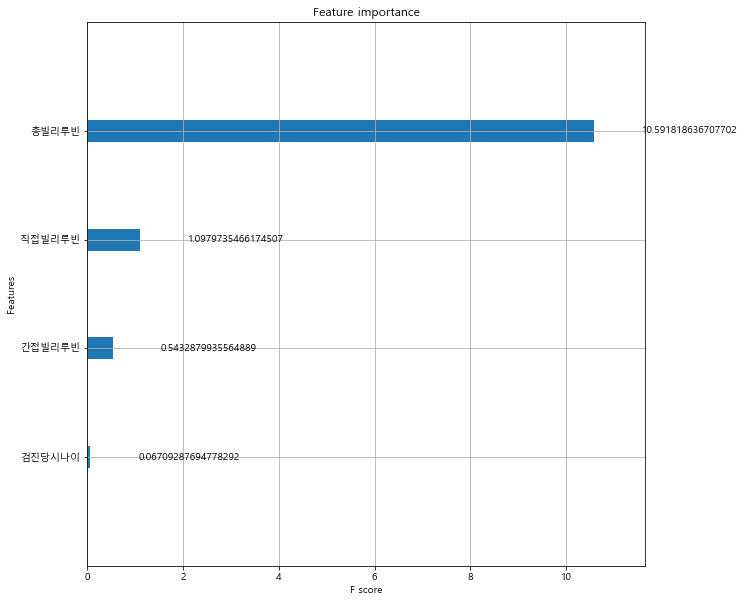

In [448]:
if XGB_bool:
    plt.rcParams["figure.figsize"] = (10, 10)
    xgboost.plot_importance(model2, importance_type='gain')

In [449]:
model2.feature_importances_

array([0.00545463, 0.86111134, 0.08926488, 0.04416913], dtype=float32)

In [450]:
df_feature2 = pd.concat([pd.DataFrame(train_columns), pd.DataFrame(model2.feature_importances_)], axis=1)
df_feature2.columns = ['columns', 'feature_importance']

In [451]:
df_feature2.sort_values('feature_importance', ascending=False)

,columns,feature_importance
1,총빌리루빈,0.861111
2,직접빌리루빈,0.089265
3,간접빌리루빈,0.044169
0,검진당시나이,0.005455


# 실제나이 - 예측나이 결과

In [452]:
df_test2 = pd.concat([pd.DataFrame(y_test2).reset_index(drop=True), pd.DataFrame(y_pred2).reset_index(drop=True)], axis=1)

In [453]:
df_test2.head()

,target,0
0,71.0,71.045021
1,130.0,130.037537
2,84.0,83.865234
3,57.0,56.955822
4,114.0,114.144905


In [454]:
df_test2.columns

Index(['target', 0], dtype='object')

In [455]:
df_test2.columns = ['실제지수', '예측지수']

In [456]:
df_test2['diff'] = df_test2['예측지수'] - df_test2['실제지수']

In [457]:
df_test2.head()

,실제지수,예측지수,diff
0,71.0,71.045021,0.045021
1,130.0,130.037537,0.037537
2,84.0,83.865234,-0.134766
3,57.0,56.955822,-0.044178
4,114.0,114.144905,0.144905


In [458]:
df_test2['diff_int'] = df_test2['diff'].round(0)

In [459]:
len(df_test2)

101629

In [460]:
df_test2.head()

,실제지수,예측지수,diff,diff_int
0,71.0,71.045021,0.045021,0.0
1,130.0,130.037537,0.037537,0.0
2,84.0,83.865234,-0.134766,-0.0
3,57.0,56.955822,-0.044178,-0.0
4,114.0,114.144905,0.144905,0.0


<AxesSubplot:>

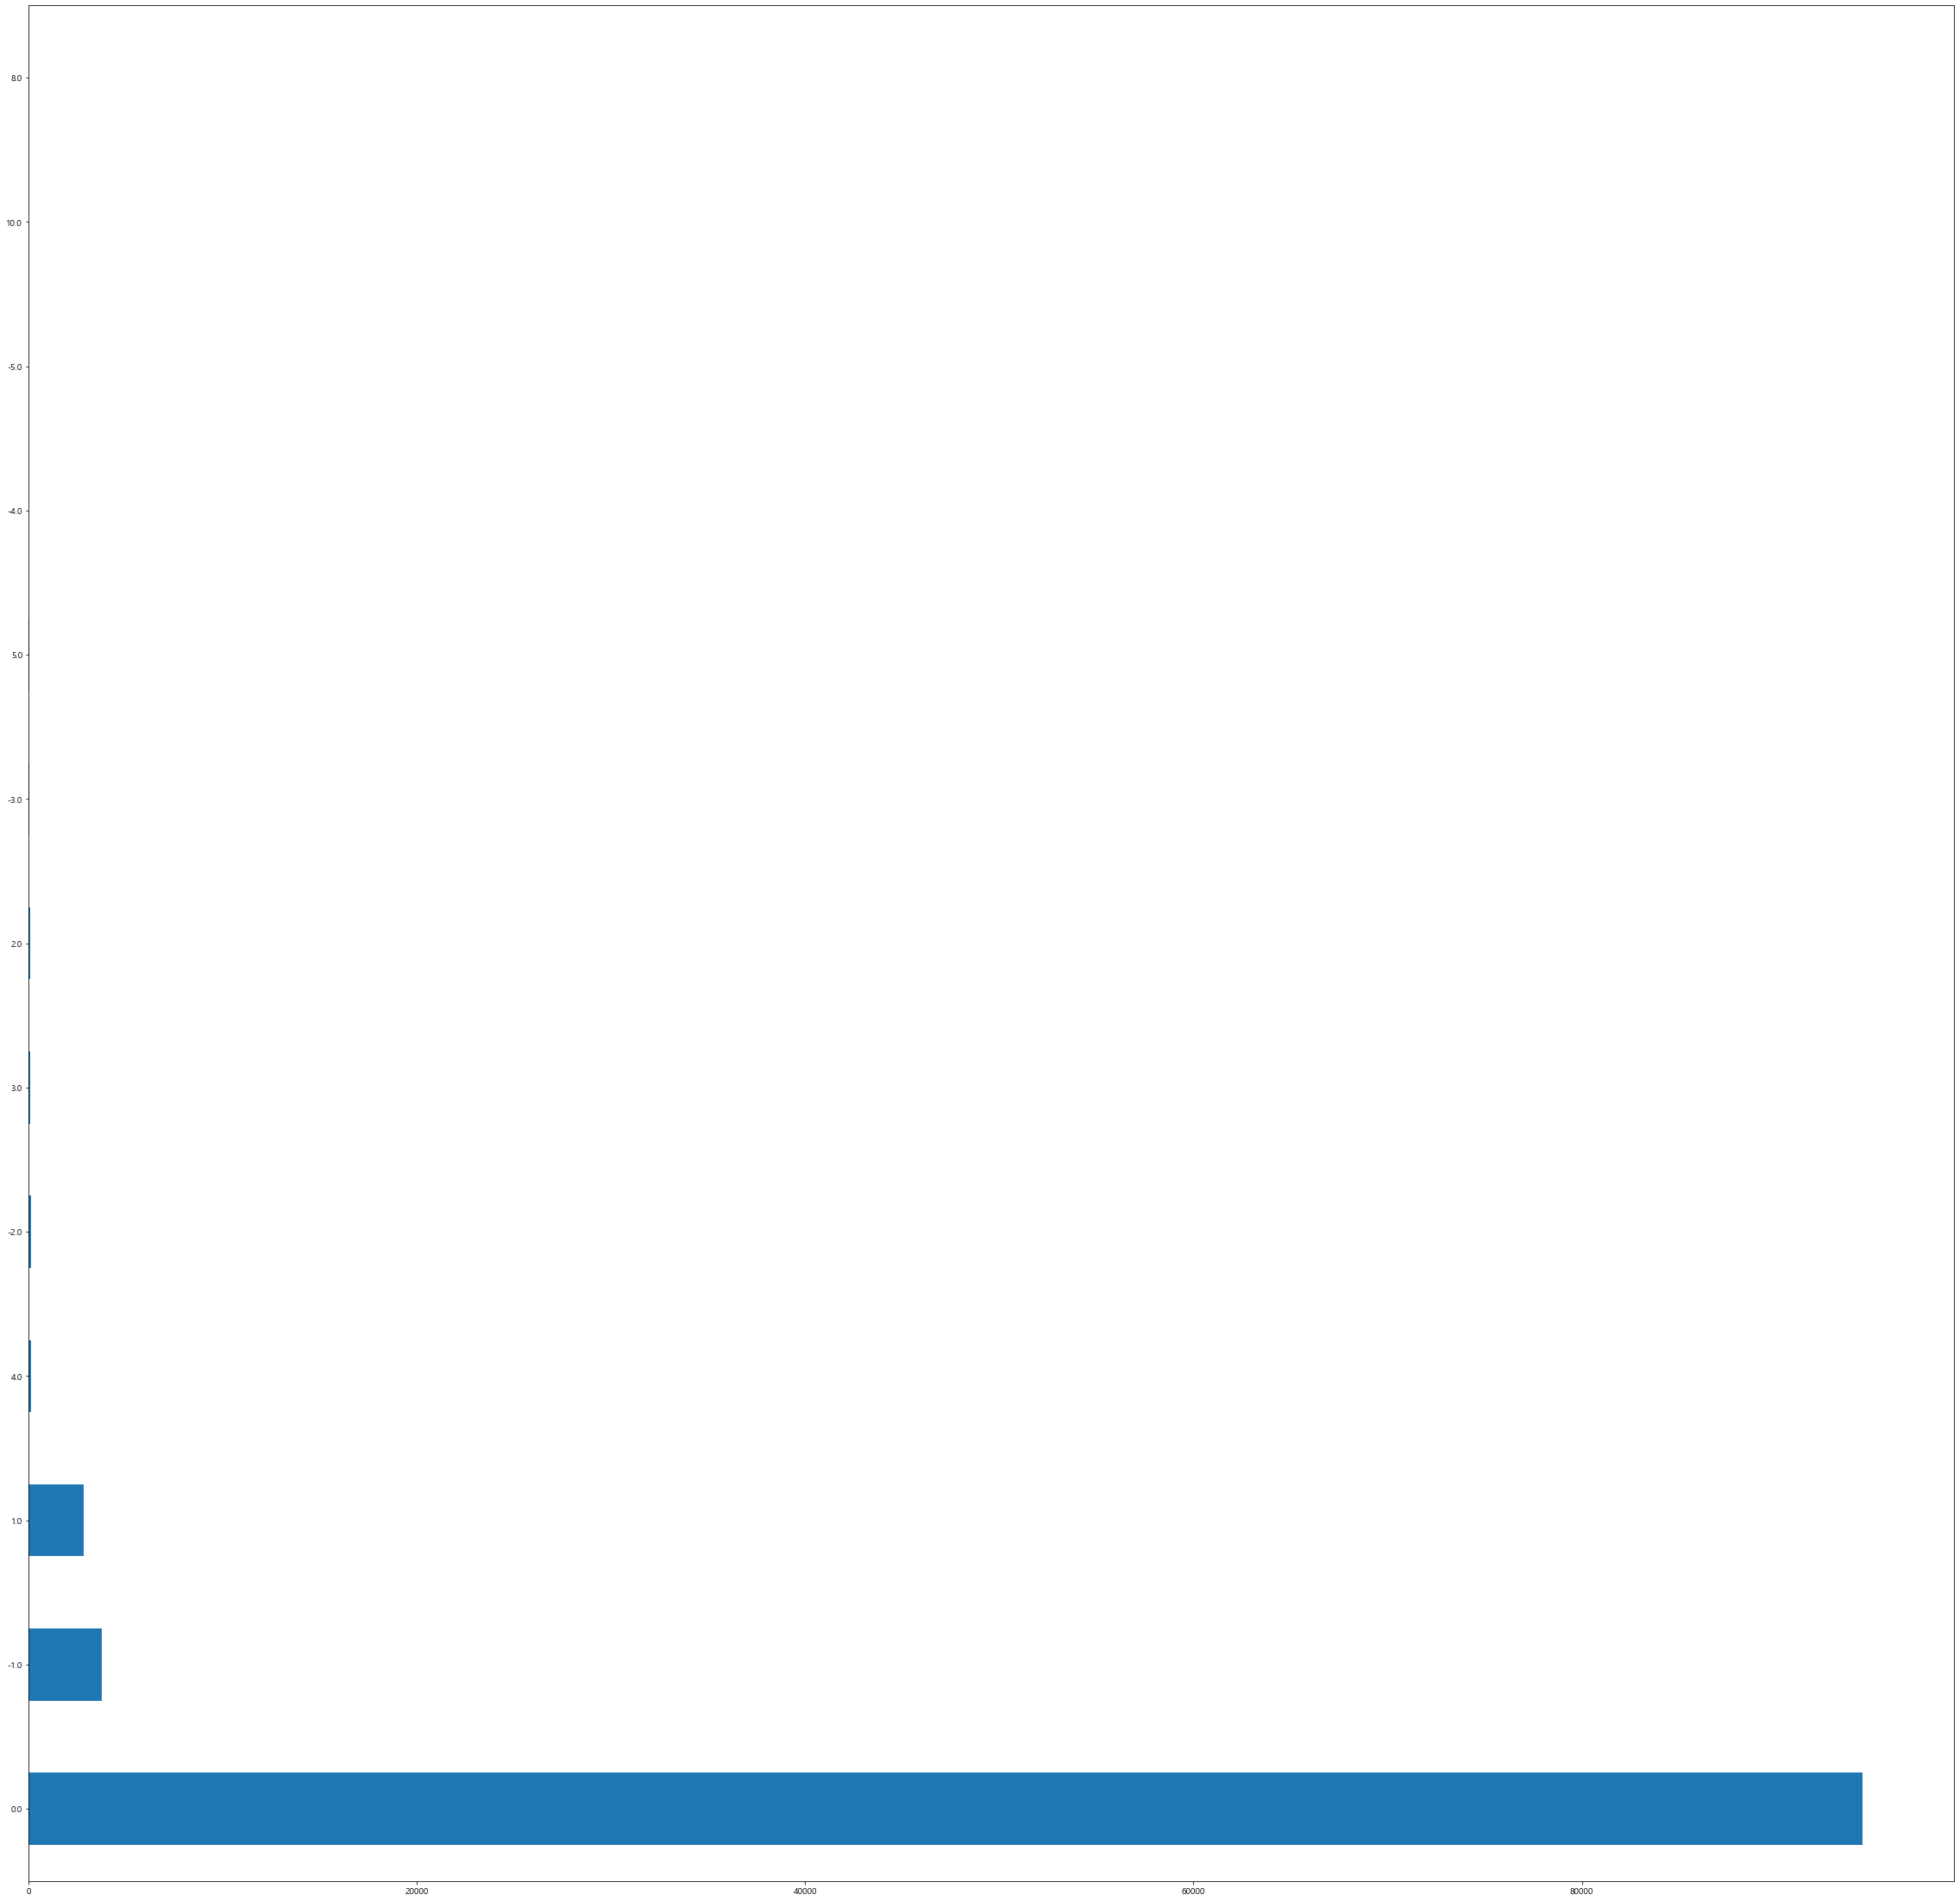

In [461]:
plt.figure(figsize=(40, 40))
df_test2['diff_int'].value_counts().plot(kind='barh')
# plt.savefig('./output/png/숙취나이_결측치제거_20대_여자.png')

In [462]:
df_test2['diff_int'].value_counts(ascending=False)

 0.0     94442
-1.0      3799
 1.0      2857
 4.0       139
-2.0       128
 3.0       109
 2.0        73
-3.0        43
 5.0        27
-4.0         7
-5.0         3
 10.0        1
 8.0         1
Name: diff_int, dtype: int64

# 예측 나이 분포

In [463]:
if pyTorch_bool:
    # Get predictions
    with torch.no_grad():
        model2.eval()
        X_train_pred2 = model2(X_train2)
        X_train_pred2 = X_train_pred2.numpy()

    df_train2 = pd.DataFrame(X_train_pred2).reset_index(drop=True)
    y_test2 = pd.DataFrame(y_test2.numpy())

In [464]:
if XGB_bool:
    df_train2 = pd.DataFrame(model2.predict(X_train2)).reset_index(drop=True)

In [465]:
df_train2 = pd.DataFrame(model2.predict(X_train2)).reset_index(drop=True)

In [466]:
df_train2.round(0).value_counts()

100.0    14710
93.0      8148
107.0     8059
99.0      7345
108.0     7295
92.0      7118
98.0      6857
97.0      6740
101.0     6719
102.0     6647
103.0     6628
90.0      6386
94.0      6376
110.0     6300
106.0     6275
109.0     5409
91.0      5399
111.0     4806
89.0      4784
96.0      4224
104.0     4178
86.0      4070
114.0     3974
105.0     3834
88.0      3758
112.0     3737
81.0      3655
95.0      3652
85.0      3648
119.0     3590
115.0     3546
120.0     3319
79.0      3284
121.0     3267
80.0      3234
118.0     3188
82.0      3157
77.0      3123
123.0     3101
83.0      3097
117.0     3086
84.0      3038
116.0     3028
128.0     2778
72.0      2739
113.0     2733
127.0     2697
87.0      2695
73.0      2616
76.0      2356
124.0     2297
129.0     2256
71.0      2219
67.0      2213
74.0      2198
133.0     2185
126.0     2133
78.0      2108
122.0     2062
125.0     2003
134.0     1996
68.0      1963
66.0      1947
75.0      1933
132.0     1918
136.0     1636
64.0      

In [467]:
y_test2.value_counts()

100.0    5023
107.0    2787
93.0     2676
92.0     2339
97.0     2286
108.0    2282
103.0    2263
99.0     2224
101.0    2202
102.0    2200
98.0     2178
110.0    2176
94.0     2156
90.0     2133
106.0    2095
109.0    1878
91.0     1836
111.0    1673
89.0     1652
104.0    1476
96.0     1437
114.0    1347
86.0     1285
105.0    1260
112.0    1260
95.0     1243
88.0     1223
119.0    1209
115.0    1207
81.0     1173
85.0     1168
80.0     1128
117.0    1074
123.0    1073
79.0     1070
121.0    1069
120.0    1060
82.0     1043
118.0    1039
83.0     1033
77.0     1012
116.0    1010
84.0     1001
72.0      935
128.0     920
113.0     919
73.0      911
87.0      871
127.0     859
71.0      777
124.0     767
76.0      765
133.0     757
67.0      746
126.0     730
78.0      724
129.0     723
122.0     700
74.0      694
66.0      646
132.0     640
75.0      625
125.0     622
134.0     607
68.0      607
135.0     564
64.0      555
69.0      554
65.0      550
131.0     535
136.0     522
70.0  

In [468]:
df_plot = pd.DataFrame(y_test2.value_counts())

In [469]:
df_plot.columns = ['count']

In [470]:
df_plot.reset_index(inplace=True)

In [471]:
df_plot = df_plot.sort_values('index', ascending=True)

In [472]:
df_plot.set_index('index', inplace=True)

<AxesSubplot:xlabel='index'>

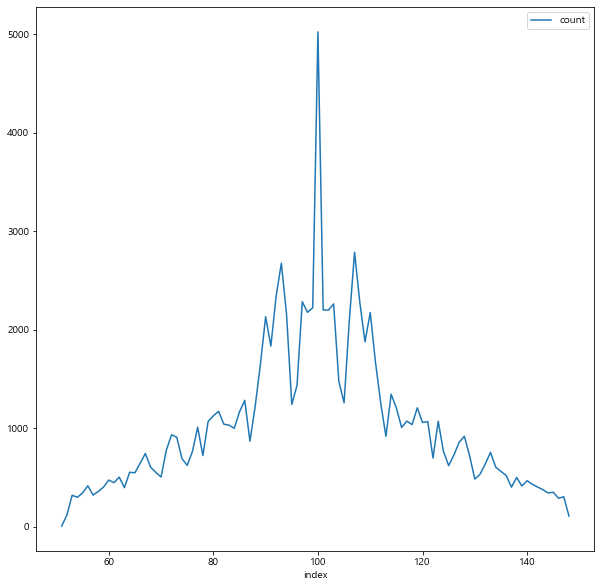

In [473]:
df_plot.plot()

In [474]:
if pyTorch_bool:
    # Get predictions
    with torch.no_grad():
        model2.eval()
        X_test_pred2 = model2(X_test2)
        X_test_pred2 = X_test_pred2.numpy()
    df_test2 = pd.DataFrame(X_test_pred2).reset_index(drop=True)

In [475]:
if XGB_bool:
    df_test2 = pd.DataFrame(model2.predict(X_test2)).reset_index(drop=True)

In [476]:
df_test2.round(0).value_counts()

100.0    4766
107.0    2785
93.0     2650
99.0     2471
92.0     2332
97.0     2315
108.0    2300
98.0     2254
102.0    2208
101.0    2208
103.0    2206
94.0     2199
110.0    2189
90.0     2136
106.0    2063
109.0    1867
91.0     1810
111.0    1688
89.0     1629
104.0    1503
96.0     1428
114.0    1332
86.0     1282
105.0    1268
112.0    1258
88.0     1238
115.0    1203
119.0    1195
95.0     1186
85.0     1184
81.0     1163
80.0     1112
123.0    1091
121.0    1085
79.0     1076
117.0    1074
118.0    1057
120.0    1048
82.0     1047
83.0     1031
77.0     1014
116.0    1000
84.0      986
113.0     937
72.0      922
73.0      912
128.0     909
87.0      882
127.0     871
71.0      787
76.0      777
124.0     753
133.0     752
78.0      737
67.0      731
129.0     730
126.0     711
74.0      686
122.0     675
66.0      662
125.0     648
132.0     639
75.0      637
68.0      624
134.0     605
135.0     569
64.0      551
69.0      546
65.0      541
131.0     535
136.0     522
62.0  

In [477]:
df_plot2 = pd.DataFrame(df_test2.round(0).value_counts())

In [478]:
df_plot2.columns = ['count']

In [479]:
df_plot2.reset_index(inplace=True)

In [480]:
df_plot2

,0,count
0,100.0,4766
1,107.0,2785
2,93.0,2650
3,99.0,2471
4,92.0,2332
5,97.0,2315
6,108.0,2300
7,98.0,2254
8,102.0,2208
9,101.0,2208


In [481]:
df_plot2 = df_plot2.sort_values(0, ascending=True)

In [482]:
df_plot2.set_index(0, inplace=True)

In [483]:
df_plot2

,count
0,
50.0,1
51.0,9
52.0,118
53.0,333
54.0,307
55.0,340
56.0,415
57.0,314
58.0,362


<AxesSubplot:xlabel='0'>

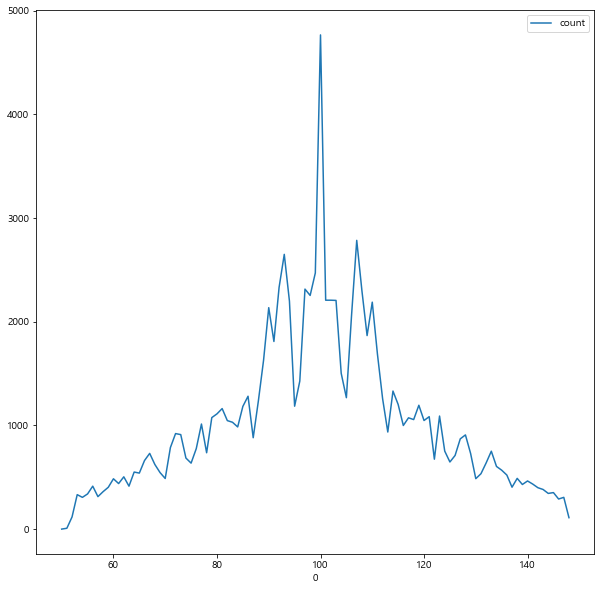

In [484]:
df_plot2.plot()

# 시각화

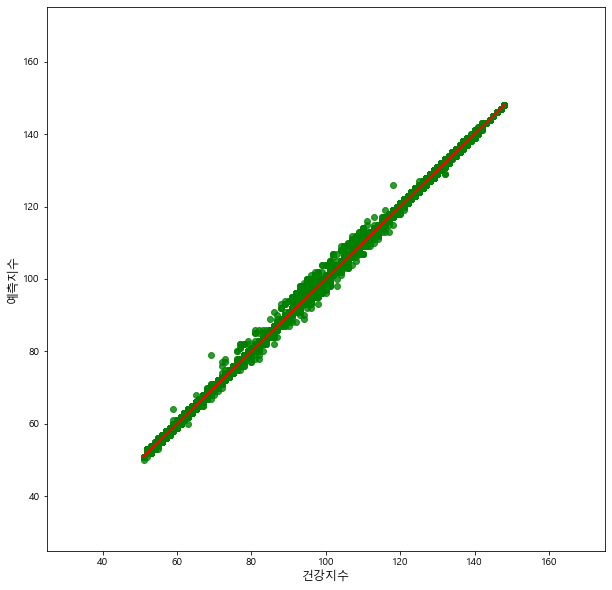

In [485]:
plt.rcParams["figure.figsize"] = (10, 10)
df_scatter = pd.concat([pd.DataFrame(y_test2).reset_index(drop=True), df_test2.round(0)], axis = 1)
df_scatter.columns = ['건강지수', '예측지수']

import seaborn as sns

# plt.figure(figsize=(10, 10))
# plt.scatter(df_scatterx='나이', y='예측나이', s=9, cmap='Reds', color='green', trendline="ols")
# plt.colorbar()
# sns.scatterplot(x=df_scatter['나이'], y=df_scatter['예측나이'], color='green')
sns.regplot(x=df_scatter['건강지수'], y=df_scatter['예측지수'], scatter_kws={'color':'green'}, line_kws={'color':'red'})
plt.xlabel('건강지수', fontsize=12)
plt.ylabel('예측지수', fontsize=12)
plt.xlim([25, 175])
plt.ylim([25, 175])
plt.show()

# 여성 데이터 전체 계산

In [486]:
df_woman.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
0,2021,53,2632765,2,26,0.60,0.20,0.40,100.96,100.00,100.16,100.52,100.0
1,2024,53,2658222,2,29,0.50,0.20,0.30,108.77,100.00,116.24,108.44,104.0
2,2020,54,497669,2,30,0.76,0.07,0.69,91.33,184.53,50.51,104.42,102.0
3,2022,54,1319859,2,32,0.80,0.20,0.60,84.79,100.00,65.78,83.84,92.0
4,2023,54,2039511,2,33,0.70,0.10,0.60,91.62,153.11,70.03,101.60,101.0


In [487]:
df_woman.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328730 entries, 0 to 328729
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   검진년도        328730 non-null  int64  
 1   UID         328730 non-null  int64  
 2   CU_REC_ID   328730 non-null  int64  
 3   SEX         328730 non-null  int64  
 4   검진당시나이      328730 non-null  int64  
 5   총빌리루빈       328730 non-null  float64
 6   직접빌리루빈      328730 non-null  float64
 7   간접빌리루빈      328730 non-null  float64
 8   총빌리루빈_kde   328730 non-null  float64
 9   직접빌리루빈_kde  328730 non-null  float64
 10  간접빌리루빈_kde  328730 non-null  float64
 11  kde_mean    328730 non-null  float64
 12  target      328730 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 32.6 MB


In [488]:
df_woman[df_woman['UID'] == 196909]

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target
72006,2021,196909,2495703,2,28,0.8,0.3,0.51,74.61,49.13,100.00,74.59,87.0
72007,2023,196909,2495700,2,30,0.6,0.3,0.30,102.96,51.25,120.13,94.32,97.0
72008,2024,196909,2495697,2,31,1.0,0.4,0.60,37.56,16.07,73.47,41.16,71.0


In [489]:
if scaling_bool:
    df_pred2 = df_woman_scaled.copy()
else:
    df_pred2 = df_woman.copy()

In [490]:
len(df_pred2)

328730

In [491]:
df_pred2.reset_index(drop=True, inplace=True)

In [492]:
X_test2

,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
9916,26,1.10,0.20,0.90
10358,26,0.34,0.14,0.20
138623,41,0.91,0.29,0.51
242327,27,1.30,0.40,0.90
57781,37,0.50,0.16,0.34
...,...,...,...,...
63897,33,0.65,0.20,0.51
213848,41,0.60,0.10,0.51
227644,47,0.90,0.20,0.70
86219,32,0.30,0.20,0.10


In [493]:
df_pred2.columns

Index(['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이', '총빌리루빈', '직접빌리루빈',
       '간접빌리루빈', '총빌리루빈_kde', '직접빌리루빈_kde', '간접빌리루빈_kde', 'kde_mean',
       'target'],
      dtype='object')

In [494]:
df_pred2[train_columns]

,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
0,26,0.60,0.20,0.40
1,29,0.50,0.20,0.30
2,30,0.76,0.07,0.69
3,32,0.80,0.20,0.60
4,33,0.70,0.10,0.60
...,...,...,...,...
328725,47,0.80,0.30,0.50
328726,50,0.40,0.20,0.20
328727,57,0.50,0.20,0.30
328728,35,0.40,0.20,0.20


In [495]:
if pyTorch_bool:
    # Get predictions
    with torch.no_grad():
        model2.eval()
        pred_data2 = model2(torch.Tensor(df_pred2[train_columns].to_numpy()))
        pred_data2 = pred_data2.numpy()

In [496]:
if XGB_bool:
    # Get predictions
    # pred_data = model.predict(df_pred[train_columns])
    pred_data2 = model2.predict(df_pred2[train_columns])

In [497]:
pred_data2

array([ 99.9764  , 104.03553 , 102.026024, ..., 109.965866, 118.051735,
       125.822205], dtype=float32)

In [498]:
df_output2 = pd.concat([df_pred2, pd.DataFrame(pred_data2, columns=['예측지수']).reset_index(drop=True)], axis=1)

In [499]:
if scaling_bool:
    df_output2 = pd.concat([df_woman[['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이']], df_output2], axis=1)

In [500]:
df_output2.head(10)

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target,예측지수
0,2021,53,2632765,2,26,0.60,0.20,0.40,100.96,100.00,100.16,100.52,100.0,99.976402
1,2024,53,2658222,2,29,0.50,0.20,0.30,108.77,100.00,116.24,108.44,104.0,104.035530
2,2020,54,497669,2,30,0.76,0.07,0.69,91.33,184.53,50.51,104.42,102.0,102.026024
3,2022,54,1319859,2,32,0.80,0.20,0.60,84.79,100.00,65.78,83.84,92.0,92.006714
4,2023,54,2039511,2,33,0.70,0.10,0.60,91.62,153.11,70.03,101.60,101.0,100.868790
5,2024,54,2750990,2,34,0.82,0.14,0.68,70.22,180.29,46.70,91.86,96.0,96.065208
6,2022,56,1351361,2,33,1.10,0.30,0.80,28.69,57.73,29.34,36.11,68.0,68.024551
7,2023,56,2032999,2,34,1.20,0.30,0.90,15.10,54.39,13.41,24.50,62.0,62.050186
8,2021,59,701026,2,29,0.90,0.20,0.70,60.48,100.00,47.70,67.16,84.0,83.936447
9,2022,59,1376992,2,30,0.90,0.30,0.60,60.87,51.25,74.99,62.00,81.0,80.976372


## 예측지수 성능평가

In [501]:
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
mean_absolute_error(df_output2['target'], df_output2['예측지수'])

0.17225483026429958

# target으로 나이 계산

In [502]:
df_output2['예측나이'] = ((100 - df_output2['예측지수']) / 5) + df_output2['검진당시나이']
df_output2['예측나이'] = df_output2['예측나이'].round(2)

In [503]:
df_output2.head(30)

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target,예측지수,예측나이
0,2021,53,2632765,2,26,0.60,0.20,0.40,100.96,100.00,100.16,100.52,100.0,99.976402,26.00
1,2024,53,2658222,2,29,0.50,0.20,0.30,108.77,100.00,116.24,108.44,104.0,104.035530,28.19
2,2020,54,497669,2,30,0.76,0.07,0.69,91.33,184.53,50.51,104.42,102.0,102.026024,29.59
3,2022,54,1319859,2,32,0.80,0.20,0.60,84.79,100.00,65.78,83.84,92.0,92.006714,33.60
4,2023,54,2039511,2,33,0.70,0.10,0.60,91.62,153.11,70.03,101.60,101.0,100.868790,32.83
5,2024,54,2750990,2,34,0.82,0.14,0.68,70.22,180.29,46.70,91.86,96.0,96.065208,34.79
6,2022,56,1351361,2,33,1.10,0.30,0.80,28.69,57.73,29.34,36.11,68.0,68.024551,39.40
7,2023,56,2032999,2,34,1.20,0.30,0.90,15.10,54.39,13.41,24.50,62.0,62.050186,41.59
8,2021,59,701026,2,29,0.90,0.20,0.70,60.48,100.00,47.70,67.16,84.0,83.936447,32.21
9,2022,59,1376992,2,30,0.90,0.30,0.60,60.87,51.25,74.99,62.00,81.0,80.976372,33.80


## 예측나이 성능평가

In [504]:
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
mean_absolute_error(df_output2['검진당시나이'], df_output2['예측나이'])

2.8608602804733376

# 최종 산출

In [505]:
df_output2.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,총빌리루빈_kde,직접빌리루빈_kde,간접빌리루빈_kde,kde_mean,target,예측지수,예측나이
0,2021,53,2632765,2,26,0.60,0.20,0.40,100.96,100.00,100.16,100.52,100.0,99.976402,26.00
1,2024,53,2658222,2,29,0.50,0.20,0.30,108.77,100.00,116.24,108.44,104.0,104.035530,28.19
2,2020,54,497669,2,30,0.76,0.07,0.69,91.33,184.53,50.51,104.42,102.0,102.026024,29.59
3,2022,54,1319859,2,32,0.80,0.20,0.60,84.79,100.00,65.78,83.84,92.0,92.006714,33.60
4,2023,54,2039511,2,33,0.70,0.10,0.60,91.62,153.11,70.03,101.60,101.0,100.868790,32.83


# DataMart csv

In [506]:
df_copy = df.copy()

In [507]:
df_copy.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
0,2010,7282,2520,1,42,1.7,0.3,NaN
1,2010,7490,3638,1,39,0.9,0.3,0.6
2,2010,7915,3997,1,36,1.4,NaN,NaN
3,2010,8056,4745,1,42,0.7,0.2,NaN
4,2010,8457,3929,1,38,1.9,NaN,NaN


In [508]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213899 entries, 0 to 1213898
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   검진년도       1213899 non-null  int64  
 1   UID        1213899 non-null  int64  
 2   CU_REC_ID  1213899 non-null  int64  
 3   SEX        1213899 non-null  int64  
 4   검진당시나이     1213899 non-null  int64  
 5   총빌리루빈      1109378 non-null  float64
 6   직접빌리루빈     1040148 non-null  float64
 7   간접빌리루빈     822450 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 74.1 MB


In [509]:
minimums

[-0.12000000000000022, 0.050000000000000044, -0.20000000000000007]

In [510]:
maximums

[1.8000000000000003, 0.44999999999999996, 1.4000000000000001]

In [511]:
train_columns

['검진당시나이', '총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [512]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [513]:
for idx, col in enumerate(target_cols):    
    df_copy.loc[df_copy[col] < minimums[idx], col] = minimums[idx]
    df_copy.loc[df_copy[col] > maximums[idx], col] = maximums[idx]

In [514]:
df_woman_csv = df_copy[df_copy['SEX'] == 2]
len(df_woman_csv)

448440

In [515]:
df_woman_csv.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈
10,2010,15894,2533,2,29,0.8,0.20,0.6
22,2010,42223,1364,2,24,0.8,0.20,0.6
37,2011,364096,6645,2,32,0.6,0.12,NaN
45,2010,120518,3595,2,30,0.8,0.30,0.5
63,2011,698706,6600,2,36,NaN,NaN,NaN


## 검진 항목 all 결측치 지우기

In [516]:
target_cols

['총빌리루빈', '직접빌리루빈', '간접빌리루빈']

In [517]:
df_woman_csv.dropna(subset=target_cols, how='all', inplace=True)

In [518]:
df_woman_csv.reset_index(drop=True, inplace=True)

In [519]:
len(df_woman_csv)

406602

## fillna

In [520]:
df_woman.columns

Index(['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이', '총빌리루빈', '직접빌리루빈',
       '간접빌리루빈', '총빌리루빈_kde', '직접빌리루빈_kde', '간접빌리루빈_kde', 'kde_mean',
       'target'],
      dtype='object')

In [521]:
df_woman_csv.columns

Index(['검진년도', 'UID', 'CU_REC_ID', 'SEX', '검진당시나이', '총빌리루빈', '직접빌리루빈',
       '간접빌리루빈'],
      dtype='object')

In [522]:
df_woman_csv.fillna(df_woman.mean().round(2), inplace=True)

## 스크리닝

In [523]:
# screening = 80

In [524]:
# df_woman_csv[df_woman_csv['ALP'] < screening].head()

In [525]:
# len(df_woman_csv[df_woman_csv['ALP'] < screening])

In [526]:
# df_woman_csv.loc[df_woman_csv['ALP'] < screening, 'ALP'] = screening

In [527]:
# df_woman_csv[df_woman_csv['ALP'] < screening].head()

In [528]:
# len(df_woman_csv[df_woman_csv['ALP'] < screening])

In [529]:
# len(df_woman_csv)

## 모델 예측

In [530]:
if XGB_bool:
    # Get predictions
    # pred_data = model.predict(df_pred[train_columns])
    pred_data2 = model2.predict(df_woman_csv[train_columns])

In [531]:
pred_data2 = pred_data2.round(0)

In [532]:
df_woman_csv = pd.concat([df_woman_csv, pd.DataFrame(pred_data2, columns=['예측지수']).reset_index(drop=True)], axis=1)

In [533]:
df_woman_csv.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수
0,2010,15894,2533,2,29,0.8,0.20,0.60,91.0
1,2010,42223,1364,2,24,0.8,0.20,0.60,93.0
2,2011,364096,6645,2,32,0.6,0.12,0.51,107.0
3,2010,120518,3595,2,30,0.8,0.30,0.50,90.0
4,2010,167053,3087,2,26,0.5,0.10,0.40,111.0


### 성능 평가

In [534]:
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
# print('MAE :',mean_absolute_error(df_woman_csv['target'], df_woman_csv['예측지수']))

In [535]:
# r2_score(df_woman_csv['target'], df_woman_csv['예측지수'])

## 예측나이 계산

In [536]:
df_woman_csv['예측나이'] = ((100 - df_woman_csv['예측지수']) / 5) + df_woman_csv['검진당시나이']
df_woman_csv['예측나이'] = df_woman_csv['예측나이'].round(2)

### 성능 평가

In [537]:
# MAE (Mean Absolute Error) : 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화
print('MAE :',mean_absolute_error(df_woman_csv['검진당시나이'], df_woman_csv['예측나이']))

MAE : 3.06955253540317


In [538]:
r2_score(df_woman_csv['검진당시나이'], df_woman_csv['예측나이'])

0.7763896444252925

In [539]:
df_woman_csv.head()

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
0,2010,15894,2533,2,29,0.8,0.20,0.60,91.0,30.8
1,2010,42223,1364,2,24,0.8,0.20,0.60,93.0,25.4
2,2011,364096,6645,2,32,0.6,0.12,0.51,107.0,30.6
3,2010,120518,3595,2,30,0.8,0.30,0.50,90.0,32.0
4,2010,167053,3087,2,26,0.5,0.10,0.40,111.0,23.8


In [540]:
df_woman_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406602 entries, 0 to 406601
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   검진년도       406602 non-null  int64  
 1   UID        406602 non-null  int64  
 2   CU_REC_ID  406602 non-null  int64  
 3   SEX        406602 non-null  int64  
 4   검진당시나이     406602 non-null  int64  
 5   총빌리루빈      406602 non-null  float64
 6   직접빌리루빈     406602 non-null  float64
 7   간접빌리루빈     406602 non-null  float64
 8   예측지수       406602 non-null  float32
 9   예측나이       406602 non-null  float64
dtypes: float32(1), float64(4), int64(5)
memory usage: 29.5 MB


# 최종 UID별 확인

In [541]:
# 성윤..
df_woman_csv[df_woman_csv['UID'] == 261581].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
107386,2021,261581,806568,2,50,0.7,0.2,0.5,96.0,50.8
107394,2021,261581,2243879,2,50,0.7,0.2,0.5,96.0,50.8
107395,2021,261581,2418909,2,50,0.7,0.2,0.5,96.0,50.8
107396,2021,261581,2418910,2,50,0.7,0.2,0.5,96.0,50.8
167722,2022,261581,751339,2,51,0.6,0.2,0.4,101.0,50.8
167725,2022,261581,2243878,2,51,0.6,0.2,0.4,101.0,50.8
257120,2023,261581,1519764,2,52,0.9,0.3,0.6,82.0,55.6
257121,2023,261581,2243877,2,52,0.9,0.3,0.6,82.0,55.6
372970,2024,261581,2418911,2,53,0.8,0.3,0.5,88.0,55.4


In [542]:
# 차종..
df_woman_csv[df_woman_csv['UID'] == 477944].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
53503,2022,477944,956268,2,31,0.7,0.3,0.4,92.0,32.6
198701,2022,477944,2212776,2,31,0.7,0.3,0.4,92.0,32.6
300332,2023,477944,1454346,2,32,1.0,0.4,0.6,71.0,37.8
300333,2023,477944,2212775,2,32,1.0,0.4,0.6,71.0,37.8
385238,2024,477944,2362855,2,33,0.7,0.3,0.4,93.0,34.4


In [543]:
# 성혜빈
df_woman_csv[df_woman_csv['UID'] == 896916].sort_values(['검진년도', 'CU_REC_ID'])

,검진년도,UID,CU_REC_ID,SEX,검진당시나이,총빌리루빈,직접빌리루빈,간접빌리루빈,예측지수,예측나이
325409,2023,896916,1459636,2,28,0.6,0.2,0.4,100.0,28.0
325398,2023,896916,1842092,2,28,0.6,0.2,0.4,100.0,28.0
325410,2023,896916,2031853,2,28,0.6,0.2,0.4,100.0,28.0
325411,2023,896916,2253054,2,28,0.6,0.2,0.4,100.0,28.0
319730,2023,896916,2257188,2,28,0.6,0.2,0.4,100.0,28.0
395995,2024,896916,2253058,2,29,0.4,0.2,0.2,115.0,26.0


# 최종 CSV 병합 Extract

In [544]:
len(df_man_csv)

703698

In [545]:
len(df_woman_csv)

406602

In [546]:
df_csv = pd.concat([df_man_csv, df_woman_csv])

In [547]:
df_csv.to_csv(csv_path)